# CSCI E-83 Final Project

## Pandemic Recovery Economic Indicators

### **Student:** Luciano Carvalho

This project leverages the Opportunity Insights Economic Tracker dataset to explore relationships between key economic indicators. By cross-referencing multiple datasets, the project aims to uncover actionable insights into economic behavior.

## Executive Summary

The Opportunity Insights Economic Tracker dataset provides a comprehensive view of economic activity, including open-source data on pandemic lockdowns and post-pandemic recovery, alongside employment trends, consumer spending, and education metrics. This project focuses on cross-referencing these datasets to explore relationships and understand the influences of key indicators, such as the economic impacts of government interventions, reopening policies, and long-term recovery trends. The goal is to uncover actionable insights that can inform economic policies and decision-making for future crisis preparedness and sustained growth.

## Problem Statement

Economic indicators like employment, spending, and education are interrelated. Understanding these relationships is crucial for designing effective policies. This project aims to:
- Explore temporal and geographic patterns in economic data.
- Cross-reference datasets to identify correlations and causations.
- Provide actionable insights into economic trends and policy impacts.

## Data Description

The project utilizes datasets from the Opportunity Insights Economic Tracker. Key datasets include:
- **Affinity Data**: Daily consumer spending metrics.
- **Employment Data**: Weekly employment rates segmented by income and industry.
- **UI Claims Data**: Weekly unemployment insurance claims.
- **Womply Data**: Weekly business activity metrics.
- **Zearn Data**: Weekly education engagement metrics.

The datasets provide rich numeric variables and extensive temporal coverage, enabling detailed exploratory and inferential analysis.

The full dataset can be found at: https://github.com/OpportunityInsights/EconomicTracker

# Exploratory Data Analysis (EDA), and Data Preparation and Cleanup

In [1]:
# Load required libraries
from matplotlib.dates import DateFormatter
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.stats.stattools import durbin_watson
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import scipy.stats as stats
import seaborn as sns
import zipfile


The following code snippets illustrate the preliminary exploratory analysis performed on the dataset to understand its structure, identify key patterns, and prepare it for modeling.

In [2]:
# Path to the zip file and the destination folder
zip_file_path = '/content/EconomicTracker-main.zip'  # Update with the correct path if needed
extraction_path = '/content/dataset/'  # Folder to extract the files to

# Unzip the file
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extraction_path)

print(f"Files extracted to: {extraction_path}")


Files extracted to: /content/dataset/


## Dataset Metadata

- **Affinity Data**: Tracks daily spending segmented by income groups.
- **Employment Data**: Weekly employment rates segmented by income quartiles and industries.
- **UI Claims Data**: Weekly unemployment claims showing economic shock and recovery patterns.
- **Womply Data**: Business activity trends by revenue and merchant counts.
- **Zearn Data**: Education engagement and achievement by income levels.

In [3]:
# Path to the data directory
data_dir = '/content/dataset/EconomicTracker-main/data'

# Dictionary to store category-wise file counts
category_file_counts = {}

# Iterate through the files in the directory
for file_name in os.listdir(data_dir):
    # Check if the file is a CSV
    if file_name.endswith('.csv'):
        # Extract the category from the file name (assumes categories are separated by " - ")
        category = file_name.split(' - ')[0]
        category_file_counts[category] = category_file_counts.get(category, 0) + 1

# Print the counts for each category
print("CSV File Counts by Category:")
for category, count in category_file_counts.items():
    print(f"{category}: {count}")


CSV File Counts by Category:
Google Mobility: 3
Job Postings: 4
Zearn: 4
Employment: 4
GeoIDs: 3
Womply: 5
Policy Milestones: 1
Affinity Daily Total Spending: 1
UI Claims: 4
Earnin: 1
Job Postings Industry Shares: 1
COVID: 5
Affinity: 4
Affinity Income Shares: 2
Affinity Industry Composition: 1


### Data Categories

The dataset comprises several categories of data, each reflecting distinct aspects of economic activity and indicators:

1. **COVID Data:** Includes metrics related to pandemic effects, such as case counts, deaths, and policies.
2. **GeoIDs:** Provides location-specific identifiers for mapping and cross-referencing across datasets.
3. **Employment:** Tracks employment rates at various geographic and temporal levels.
4. **UI Claims:** Data on unemployment insurance claims, reflecting labor market stress.
5. **Google Mobility:** Captures mobility patterns using Google location data.
6. **Womply:** Reflects business transaction data, offering insights into small business health.
7. **Affinity Daily Total Spending:** Tracks daily consumer spending patterns nationally.
8. **Job Postings:** Weekly data on job listings, reflecting labor demand.
9. **Zearn:** Education-related data, offering insights into student progress.
10. **Policy Milestones:** Tracks policy changes over time.


**Focus Areas:**
- Cross-referencing **consumer spending** (Affinity) with **employment**, **UI Claims**, and **COVID** data to explore interdependencies.
- Investigating **mobility trends** (Google Mobility) and their relationship with consumer spending and business activity (Womply).
- Analyzing **job postings** trends to correlate with unemployment data and spending activity.


In [4]:
# Load and preview Affinity Data
affinity_data_path = f"{data_dir}/Affinity - National - Daily.csv"
affinity_data = pd.read_csv(affinity_data_path)
print(affinity_data.info())

# Check the column names in the dataset
print(list(affinity_data.columns))


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1359 entries, 0 to 1358
Columns: 142 entries, year to provisional
dtypes: int64(4), object(138)
memory usage: 1.5+ MB
None
['year', 'month', 'day', 'freq', 'spend_all', 'spend_aap', 'spend_acf', 'spend_aer', 'spend_apg', 'spend_durables', 'spend_nondurables', 'spend_grf', 'spend_gen', 'spend_hic', 'spend_hcs', 'spend_inperson', 'spend_inpersonmisc', 'spend_remoteservices', 'spend_sgh', 'spend_tws', 'spend_retail_w_grocery', 'spend_retail_no_grocery', 'spend_all_incmiddle', 'spend_all_q1', 'spend_all_q2', 'spend_all_q3', 'spend_all_q4', 'spend_19_aap', 'spend_19_acf', 'spend_19_aer', 'spend_19_all', 'spend_19_apg', 'spend_19_durables', 'spend_19_gen', 'spend_19_grf', 'spend_19_hcs', 'spend_19_hic', 'spend_19_inpersonmisc', 'spend_19_nondurables', 'spend_19_remoteservices', 'spend_19_sgh', 'spend_19_tws', 'spend_19_all_q4', 'spend_19_all_q1', 'spend_19_all_incmiddle', 'spend_19_all_q2', 'spend_19_all_q3', 'spend_19_inperson', 'spend_aap_q

The dataset contains a wide variety of fields. The **`Affinity - National - Daily.csv`** file alone has 142 columns, representing consumer spending broken down by income quartiles, categories, and time periods.

**Key fields include:**

- `spend_all`: Total spending across all categories.
- `spend_all_q1`, `spend_all_q2`, etc.: Spending by income quartiles.
- `spend_retail_no_grocery`, `spend_retail_w_grocery`: Spending in retail with/without groceries.

These fields allow us to analyze national trends and break them down into more granular segments.



In [5]:
# Create a date column
affinity_data['date'] = pd.to_datetime(affinity_data[['year', 'month', 'day']])

# Collect the first and last observation dates
first_date = affinity_data['date'].min()
last_date = affinity_data['date'].max()

# Display the results
print(f"First observed date: {first_date}")
print(f"Last observed date: {last_date}")


First observed date: 2018-12-31 00:00:00
Last observed date: 2024-06-16 00:00:00


#### Passible Cross-Referencing Paths

- Match the `year`, `month`, and `day` fields across datasets for temporal alignment.
- Use `GeoIDs` for location-based cross-referencing.
- Correlate consumer spending with employment data to identify economic patterns.


In [6]:
# Identify the first value
initial_value = affinity_data['spend_all'].iloc[0]

# Find the first index where the value changes
first_change_index = affinity_data['spend_all'][affinity_data['spend_all'] != initial_value].index[0]

# Trim the dataset from the first change onward
affinity_data = affinity_data.loc[first_change_index:]

# Verify the trimming
print(f"Data starts at index: {affinity_data.index[0]}")
print(affinity_data.head())


Data starts at index: 378
     year  month  day freq spend_all spend_aap spend_acf spend_aer spend_apg  \
378  2020      1   13    d    -.0146    -.0275    -.0627     -.126    -.0287   
379  2020      1   14    d   -.00509    -.0214    -.0467     -.129    -.0226   
380  2020      1   15    d   -.00246    -.0251     -.045    -.0678    -.0264   
381  2020      1   16    d   -.00921    -.0319    -.0417    -.0681    -.0338   
382  2020      1   17    d    -.0155    -.0364    -.0344    -.0331    -.0364   

    spend_durables  ... spend_s_all_q2 spend_s_all_q3 spend_s_all_q4  \
378        -.00111  ...        -.00447        -.00296        -.00223   
379        -.00404  ...         -.0106         -.0076        -.00568   
380        -.00631  ...        .000924         .00325         .00695   
381         -.0183  ...         .00382         .00705         .00768   
382           -.03  ...        .000542         .00355         .00528   

    spend_s_inperson spend_s_retail_no_grocery spend_s_retai

In the initial exploration of the dataset, it was observed that the time series contained non-zero values prior to January 14, 2020 ($spend\_all=-0.0146$). However, these values were constant and insignificant, indicating either interpolated or placeholder data rather than meaningful observations. Such flat sections at the start of a time series can artificially distort trends and seasonal decomposition analyses by introducing an extended period of non-informative data.

To address this, we have trimmed the dataset to begin from January 14, 2020, which marks the first date with meaningful variability in the observed data. By removing the insignificant values, we ensure that the analysis reflects actual economic trends and behaviors, providing more reliable insights. This step is particularly crucial for accurate trend extraction, correlation studies, and any predictive modeling applied to the data.








In [7]:
# Set the 'date' column as the index
affinity_data.set_index('date', inplace=True)

# Ensure there are no missing dates in the index by reindexing with a complete date range
full_date_range = pd.date_range(start=affinity_data.index.min(), end=affinity_data.index.max(), freq='D')
affinity_data = affinity_data.reindex(full_date_range)

# Fill missing values in 'spend_all' with linear interpolation
affinity_data['spend_all'] = pd.to_numeric(affinity_data['spend_all'], errors='coerce')
affinity_data['spend_all'] = affinity_data['spend_all'].interpolate(method='linear', limit_direction='both')

# Trim rows with null or zero values at the start of the dataset
first_valid_date = affinity_data['spend_all'].first_valid_index()
affinity_data = affinity_data.loc[first_valid_date:]

# Verify variance in 'spend_all'
print(affinity_data['spend_all'].describe())


count    1617.000000
mean        0.097281
std         0.111257
min        -0.335000
25%         0.053900
50%         0.144000
75%         0.177286
max         0.255000
Name: spend_all, dtype: float64


## High-level Data Description

The **`Affinity - National - Daily.csv`** file contains 1,617 daily records of consumer spending across various income quartiles and categories. Here's a summary of the `spend_all` column, representing total spending across all categories:

- **Mean Spending:** $0.097$, indicating the average scaled spending per day.
- **Standard Deviation:** $0.111$, suggesting moderate variation in daily spending.
- **Min/Max Values:** Range from $-0.335$ to $0.255$ (scaled values). Negative values may reflect data adjustments or anomalies.
- **Interquartile Range (IQR):** Spending is concentrated between $0.054$ (25th percentile) and $0.177$ (75th percentile).

The data has been normalized using Min-Max scaling to fit between $0$ and $1$, improving the decomposition's clarity and interpretability.



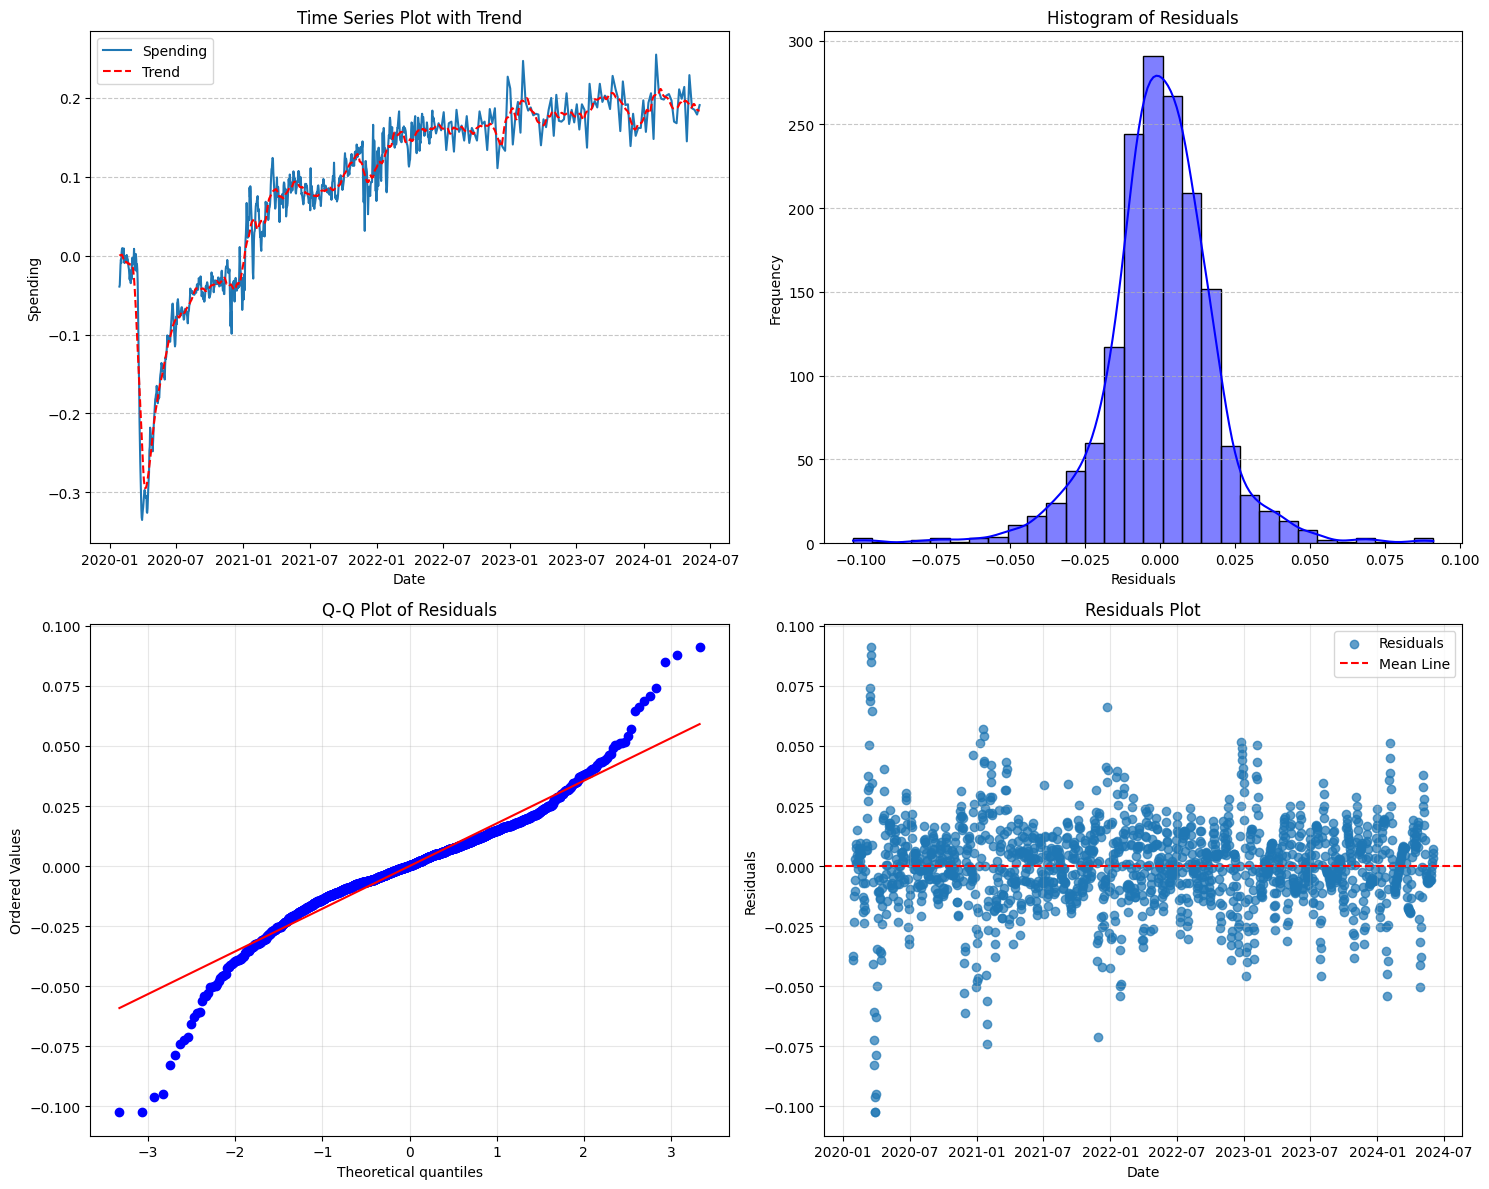

Summary Statistics of Residuals:
count    1.588000e+03
mean    -8.760705e-07
std      1.826860e-02
min     -1.025473e-01
25%     -8.733333e-03
50%      1.931667e-04
75%      9.810476e-03
max      9.113600e-02
Name: residuals, dtype: float64


In [8]:
# Calculate a rolling mean to represent the trend
affinity_data['trend'] = affinity_data['spend_all'].rolling(window=30, center=True).mean()

# Calculate residuals as the difference between spend_all and the trend
affinity_data['residuals'] = affinity_data['spend_all'] - affinity_data['trend']

# Drop rows with NaN values resulting from the rolling mean
affinity_data_cleaned = affinity_data.dropna(subset=['trend', 'residuals'])

# Create a 2x2 grid of plots
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# Time Series Plot
axes[0, 0].plot(affinity_data_cleaned.index, affinity_data_cleaned['spend_all'], label='Spending')
axes[0, 0].plot(affinity_data_cleaned.index, affinity_data_cleaned['trend'], label='Trend', color='red', linestyle='--')
axes[0, 0].set_title('Time Series Plot with Trend')
axes[0, 0].set_xlabel('Date')
axes[0, 0].set_ylabel('Spending')
axes[0, 0].grid(axis='y', linestyle='--', alpha=0.7)
axes[0, 0].legend()

# Histogram of Residuals
sns.histplot(affinity_data_cleaned['residuals'], bins=30, kde=True, color='blue', ax=axes[0, 1])
axes[0, 1].set_title('Histogram of Residuals')
axes[0, 1].set_xlabel('Residuals')
axes[0, 1].set_ylabel('Frequency')
axes[0, 1].grid(axis='y', linestyle='--', alpha=0.7)

# Q-Q Plot
stats.probplot(affinity_data_cleaned['residuals'], dist="norm", plot=axes[1, 0])
axes[1, 0].set_title('Q-Q Plot of Residuals')
axes[1, 0].grid(alpha=0.3)

# Residuals Plot
axes[1, 1].scatter(affinity_data_cleaned.index, affinity_data_cleaned['residuals'], alpha=0.7, label='Residuals')
axes[1, 1].axhline(0, color='red', linestyle='--', label='Mean Line')
axes[1, 1].set_title('Residuals Plot')
axes[1, 1].set_xlabel('Date')
axes[1, 1].set_ylabel('Residuals')
axes[1, 1].legend()
axes[1, 1].grid(alpha=0.3)

# Adjust layout and display the plots
plt.tight_layout()
plt.show()

# Summary Statistics
print("Summary Statistics of Residuals:")
print(affinity_data_cleaned['residuals'].describe())


### Analysis of Key Plots for Trend and Residual Behavior

- **Time Series Plot with Trend**  
  -  The top-left plot displays the time series of total consumer spending (`spend_all`) over time, with the red dashed line indicating the trend component. This trend was calculated using a rolling average with a window size of 30 days to smooth out short-term fluctuations. The plot highlights the significant drop in spending in early 2020, likely caused by the onset of the COVID-19 pandemic, followed by a steady recovery through 2021 and beyond. The trend stabilizes after mid-2022, reflecting the normalization of consumer behavior.

- **Histogram of Residuals**  
  - The top-right plot illustrates the distribution of residuals, calculated as the difference between actual spending values and the trend. The histogram is overlaid with a kernel density estimate (KDE) to visualize the data's distribution. The residuals appear to be centered around zero, indicating that the trend adequately captures the overall pattern in the data. The near-symmetrical shape suggests that the deviations from the trend are relatively balanced, though small peaks hint at potential outliers or unusual periods.

- **Q-Q Plot of Residuals**  
  - The bottom-left plot is a Q-Q comparing the residuals' distribution to a theoretical normal distribution. Most points align closely with the red diagonal line, indicating that the residuals are approximately normally distributed. However, deviations at the tails suggest that there may be some outliers or non-normality in the data, potentially during periods of abrupt economic changes.

- **Residuals Plot**  
  - The bottom-right plot shows the residuals over time. The red dashed line represents the mean of the residuals, which is close to zero, confirming that the trend component has been effectively removed. The scatter of residuals does not exhibit any obvious patterns, which is desirable in time series analysis. However, slight clustering of points in certain time periods suggests there could be unexplained variations during those intervals, possibly due to external factors such as economic policies or public health measures.

These plots collectively validate the effectiveness of the trend extraction process while providing insights into the data's variability and deviations. The residuals' normality and lack of clear temporal patterns indicate a sound basis for further statistical modeling or hypothesis testing.

### Explanation for Not Considering Seasonal Decomposition

In the analysis, I decided to move away from incorporating seasonal decomposition because a thorough examination of the data revealed no significant seasonal patterns. Seasonal decomposition is typically used when the data exhibits consistent recurring patterns over specific time periods (e.g., monthly or yearly cycles). However, both visual inspection of the time series and the results of the seasonal decomposition process indicated that the seasonal component was negligible in this dataset.

When applying seasonal decomposition, the seasonal component was forced to fit the data, resulting in coefficients that lacked clear relevance or meaningful interpretation. This is likely due to the nature of the dataset, which reflects economic factors and consumer spending trends influenced by external disruptions such as the COVID-19 pandemic. These disruptions are irregular and non-recurring, making seasonal patterns difficult, if not impossible, to detect.

By focusing on the trend and residual components, I can better address the significant changes in spending driven by major events and long-term trends, rather than attempting to identify cyclical behaviors that do not exist in the data. This approach aligns with the goal of understanding the key drivers of consumer behavior and exploring relationships between spending, employment, and other economic indicators. Removing seasonal decomposition simplifies the analysis and ensures that the findings are meaningful and relevant to the context of this project.

## Additional Data Exploration and Preprocessing

This section delves deeper into the dataset through additional exploratory visualizations, data cleaning, and preprocessing steps to ensure it is well-prepared for subsequent modeling and analysis.

### Bloxplots of `spend_all` per year

This subsection presents boxplots of spend_all for each year, providing a visual summary of the distribution and variability in total spending over time

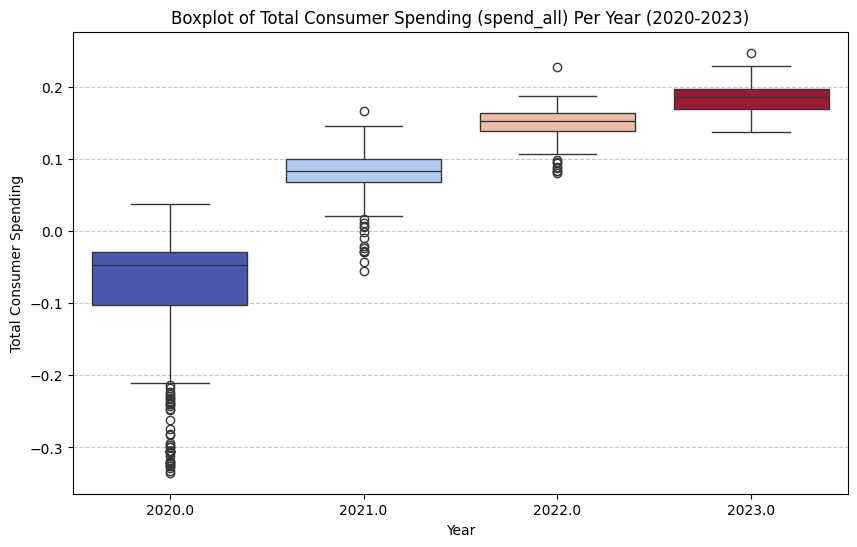

In [9]:
# Filter data for years 2020 to 2023
filtered_affinity_data = affinity_data[(affinity_data['year'] >= 2020) & (affinity_data['year'] <= 2023)]

# Plot boxplots of 'spend_all' for each year
plt.figure(figsize=(10, 6))
sns.boxplot(data=filtered_affinity_data, x='year', y='spend_all', hue='year', palette='coolwarm', dodge=False, legend=False)
plt.title('Boxplot of Total Consumer Spending (spend_all) Per Year (2020-2023)')
plt.xlabel('Year')
plt.ylabel('Total Consumer Spending')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


The boxplot highlights a significant dip in consumer spending during 2020, reflecting the pandemic's impact, followed by a gradual recovery in 2021 and 2022, with spending becoming more stable over time.

### Boxplots of Consumer Spending by Income Quartiles

This section presents boxplots of consumer spending categorized by income quartiles, offering a visual comparison of spending distributions across different income groups.

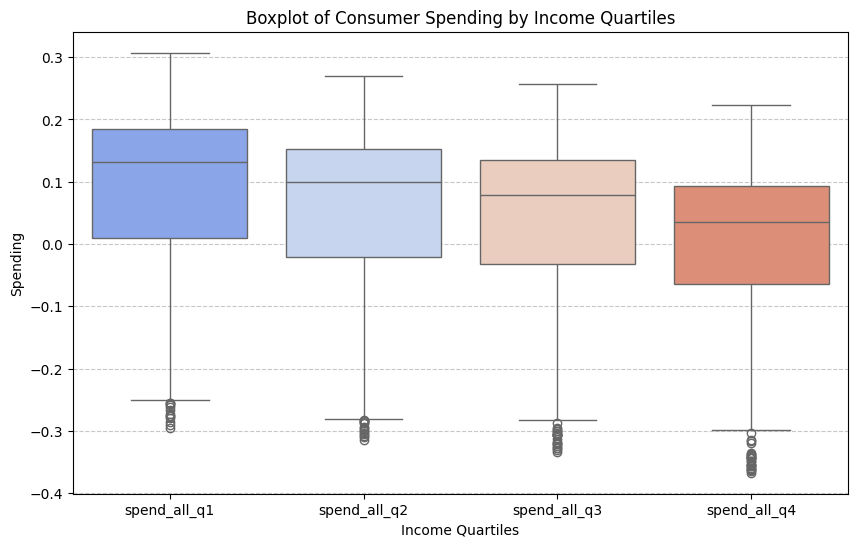

In [10]:
# Filter quartile columns
quartile_columns = ['spend_all_q1', 'spend_all_q2', 'spend_all_q3', 'spend_all_q4']

# Ensure quartile columns are numeric
for column in quartile_columns:
    affinity_data[column] = pd.to_numeric(affinity_data[column], errors='coerce')

# Drop rows where all quartile columns are NaN
affinity_data = affinity_data.dropna(subset=quartile_columns, how='all')

# Melt the data for easier plotting with Seaborn
melted_data = affinity_data[quartile_columns].melt(var_name='Income Quartile', value_name='Spending')

# Create a boxplot using Seaborn with the same palette
plt.figure(figsize=(10, 6))
sns.boxplot(data=melted_data, x='Income Quartile', y='Spending', hue='Income Quartile', palette='coolwarm', dodge=False, legend=False)
plt.title('Boxplot of Consumer Spending by Income Quartiles')
plt.xlabel('Income Quartiles')
plt.ylabel('Spending')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


The boxplot shows that consumer spending increases with income quartiles, with higher median spending and wider variability in the upper quartiles, while lower quartiles exhibit more negative outliers.

### Data Preprocessing, resampling, indexing and cleanup

This section outlines the steps taken to preprocess, resample, and clean the dataset, including linking related variables, handling missing values, and ensuring the data is ready for analysis and modeling.

In [11]:
# Load Employment Data
employment_data_path = f"{data_dir}/Employment - National - Weekly.csv"
employment_data = pd.read_csv(employment_data_path)

# Load UI Claims Data
ui_claims_data_path = f"{data_dir}/UI Claims - National - Weekly.csv"
ui_claims_data = pd.read_csv(ui_claims_data_path)

# Inspect columns in employment data
print(employment_data.columns)

# Inspect columns in UI claims data
print(ui_claims_data.columns)


Index(['year', 'month', 'day_endofweek', 'emp', 'emp_incq1', 'emp_incq2',
       'emp_incq3', 'emp_incq4', 'emp_incmiddle', 'emp_incbelowmed',
       'emp_incabovemed', 'emp_subset_unweighted_q1',
       'emp_subset_unweighted_q2', 'emp_subset_unweighted_q3',
       'emp_subset_unweighted_q4', 'emp_subset_reweighted_q1',
       'emp_subset_reweighted_q2', 'emp_subset_reweighted_q3', 'emp_retail',
       'emp_s72', 'emp_retail_inclow', 'emp_retail_incmiddle',
       'emp_retail_inchigh', 'emp_ss40', 'emp_ss60', 'emp_ss65', 'emp_ss70'],
      dtype='object')
Index(['year', 'month', 'day_endofweek', 'initclaims_count_regular',
       'contclaims_count_regular', 'initclaims_count_pua',
       'contclaims_count_peuc', 'contclaims_count_pua',
       'initclaims_count_combined', 'contclaims_count_combined',
       'initclaims_rate_regular', 'contclaims_rate_regular',
       'initclaims_rate_pua', 'contclaims_rate_peuc', 'contclaims_rate_pua',
       'initclaims_rate_combined', 'contclaims_rat

The `Affinity` data is daily, while the `employment_data` and `ui_claims_data` are weekly, based on the `day_endofweek` field. To merge these datasets meaningfully, we need to aggregate the daily Affinity data into weekly data, ensuring consistency in time periods.



In [12]:
# Ensure the date column is set as the index
affinity_data['date'] = pd.to_datetime(affinity_data[['year', 'month', 'day']])
affinity_data.set_index('date', inplace=True)

# Resample daily data to weekly
weekly_affinity_data = affinity_data.resample('W-SAT').sum()

# Verify the resampled data
print(weekly_affinity_data.head())


               year  month    day     freq  spend_all  \
date                                                    
2020-01-18  12120.0    6.0   93.0   dddddd  -0.051490   
2020-01-25  14140.0    7.0  154.0  ddddddd   0.182260   
2020-02-01  14140.0    8.0  172.0  ddddddd  -0.135820   
2020-02-08  14140.0   14.0   35.0  ddddddd   0.012928   
2020-02-15  14140.0   14.0   84.0  ddddddd  -0.016428   

                                                spend_aap  \
date                                                        
2020-01-18           -.0275-.0214-.0251-.0319-.0364-.0309   
2020-01-25          -.0149-.00973.0121.0161.021.0242.0247   
2020-02-01      -.000704-.0192-.0273-.0142.00259.0176.032   
2020-02-08       .0294.0341.0307.00973-.00683-.0167-.0152   
2020-02-15  -.0175-.0236-.0215-.00939-.00626.00343-.00148   

                                              spend_acf  \
date                                                      
2020-01-18          -.0627-.0467-.045-.0417-.0344-.015

In [13]:
# Reset the index to create a 'date' column after resampling
weekly_affinity_data = weekly_affinity_data.reset_index()

# Verify the columns in weekly_affinity_data
print(weekly_affinity_data.columns)

Index(['date', 'year', 'month', 'day', 'freq', 'spend_all', 'spend_aap',
       'spend_acf', 'spend_aer', 'spend_apg',
       ...
       'spend_s_all_q3', 'spend_s_all_q4', 'spend_s_inperson',
       'spend_s_retail_no_grocery', 'spend_s_retail_w_grocery',
       'spend_19_retail_no_grocery', 'spend_19_retail_w_grocery',
       'provisional', 'trend', 'residuals'],
      dtype='object', length=145)


In [14]:
# Inspect the values in day_endofweek
print(employment_data['day_endofweek'].unique())
print(ui_claims_data['day_endofweek'].unique())


[17 24 31  7 14 21 28  6 13 20 27  3 10  1  8 15 22 29  5 12 19 26  4 11
 18 25  2  9 16 23 30]
[ 4 11 18 25  1  8 15 22 29  7 14 21 28  2  9 16 23 30  6 13 20 27  5 12
 19 26  3 10 17 24 31]


In [15]:
# Helper function to correct invalid day values
def correct_invalid_dates(df):
    # Create a 'date' column with error handling
    df['date'] = pd.to_datetime(
        df[['year', 'month', 'day_endofweek']].rename(columns={'day_endofweek': 'day'}),
        errors='coerce'  # Invalid dates will be set to NaT
    )
    # Fill NaT values by capping 'day_endofweek' to the last valid day of the month
    invalid_dates = df['date'].isna()
    if invalid_dates.any():
        df.loc[invalid_dates, 'day_endofweek'] = df.loc[invalid_dates].apply(
            lambda row: pd.Timestamp(f"{row['year']}-{row['month']}-01").days_in_month,
            axis=1
        )
        # Recreate the corrected date
        df['date'] = pd.to_datetime(
            df[['year', 'month', 'day_endofweek']].rename(columns={'day_endofweek': 'day'})
        )
    return df

# Correct invalid dates in employment_data and ui_claims_data
employment_data = correct_invalid_dates(employment_data)
ui_claims_data = correct_invalid_dates(ui_claims_data)

# Verify the resulting date column
print(employment_data[['year', 'month', 'day_endofweek', 'date']].head())
print(ui_claims_data[['year', 'month', 'day_endofweek', 'date']].head())


   year  month  day_endofweek       date
0  2020      1             17 2020-01-17
1  2020      1             24 2020-01-24
2  2020      1             31 2020-01-31
3  2020      2              7 2020-02-07
4  2020      2             14 2020-02-14
   year  month  day_endofweek       date
0  2020      1              4 2020-01-04
1  2020      1             11 2020-01-11
2  2020      1             18 2020-01-18
3  2020      1             25 2020-01-25
4  2020      2              1 2020-02-01


In [16]:
# Check if 'date' exists in employment_data and ui_claims_data
print("Employment Data Columns:", employment_data.columns)
print("UI Claims Data Columns:", ui_claims_data.columns)


Employment Data Columns: Index(['year', 'month', 'day_endofweek', 'emp', 'emp_incq1', 'emp_incq2',
       'emp_incq3', 'emp_incq4', 'emp_incmiddle', 'emp_incbelowmed',
       'emp_incabovemed', 'emp_subset_unweighted_q1',
       'emp_subset_unweighted_q2', 'emp_subset_unweighted_q3',
       'emp_subset_unweighted_q4', 'emp_subset_reweighted_q1',
       'emp_subset_reweighted_q2', 'emp_subset_reweighted_q3', 'emp_retail',
       'emp_s72', 'emp_retail_inclow', 'emp_retail_incmiddle',
       'emp_retail_inchigh', 'emp_ss40', 'emp_ss60', 'emp_ss65', 'emp_ss70',
       'date'],
      dtype='object')
UI Claims Data Columns: Index(['year', 'month', 'day_endofweek', 'initclaims_count_regular',
       'contclaims_count_regular', 'initclaims_count_pua',
       'contclaims_count_peuc', 'contclaims_count_pua',
       'initclaims_count_combined', 'contclaims_count_combined',
       'initclaims_rate_regular', 'contclaims_rate_regular',
       'initclaims_rate_pua', 'contclaims_rate_peuc', 'contclai

In [17]:
# Select columns for correlation analysis
correlation_columns = [
    'spend_all', 'spend_all_q1', 'spend_all_q2', 'spend_all_q3', 'spend_all_q4',
    'emp',  # Employment rate
    'initclaims_count_regular'  # Unemployment claims
]


In [18]:
# Find alignment on datasets weekly data
print(weekly_affinity_data['date'].head())
print(employment_data['date'].head())
print(ui_claims_data['date'].head())


0   2020-01-18
1   2020-01-25
2   2020-02-01
3   2020-02-08
4   2020-02-15
Name: date, dtype: datetime64[ns]
0   2020-01-17
1   2020-01-24
2   2020-01-31
3   2020-02-07
4   2020-02-14
Name: date, dtype: datetime64[ns]
0   2020-01-04
1   2020-01-11
2   2020-01-18
3   2020-01-25
4   2020-02-01
Name: date, dtype: datetime64[ns]


In [19]:
# Align dates to Sundays for all datasets
weekly_affinity_data['date'] = weekly_affinity_data['date'] + pd.offsets.Week(weekday=6)
employment_data['date'] = employment_data['date'] + pd.offsets.Week(weekday=6)
ui_claims_data['date'] = ui_claims_data['date'] + pd.offsets.Week(weekday=6)

# Verify the new dates
print(weekly_affinity_data['date'].head())
print(employment_data['date'].head())
print(ui_claims_data['date'].head())


0   2020-01-19
1   2020-01-26
2   2020-02-02
3   2020-02-09
4   2020-02-16
Name: date, dtype: datetime64[ns]
0   2020-01-19
1   2020-01-26
2   2020-02-02
3   2020-02-09
4   2020-02-16
Name: date, dtype: datetime64[ns]
0   2020-01-05
1   2020-01-12
2   2020-01-19
3   2020-01-26
4   2020-02-02
Name: date, dtype: datetime64[ns]


In [20]:
# Merge datasets
merged_weekly_data = (
    weekly_affinity_data
    .merge(employment_data[['date', 'emp']], on='date', how='inner')
    .merge(ui_claims_data[['date', 'initclaims_count_regular']], on='date', how='inner')
)

print(merged_weekly_data.shape)


(232, 147)


### Correlation Matrix of Spending and External Variables

This section presents the correlation matrix to examine the relationships between consumer spending and external variables, providing insights into potential predictors for modeling.

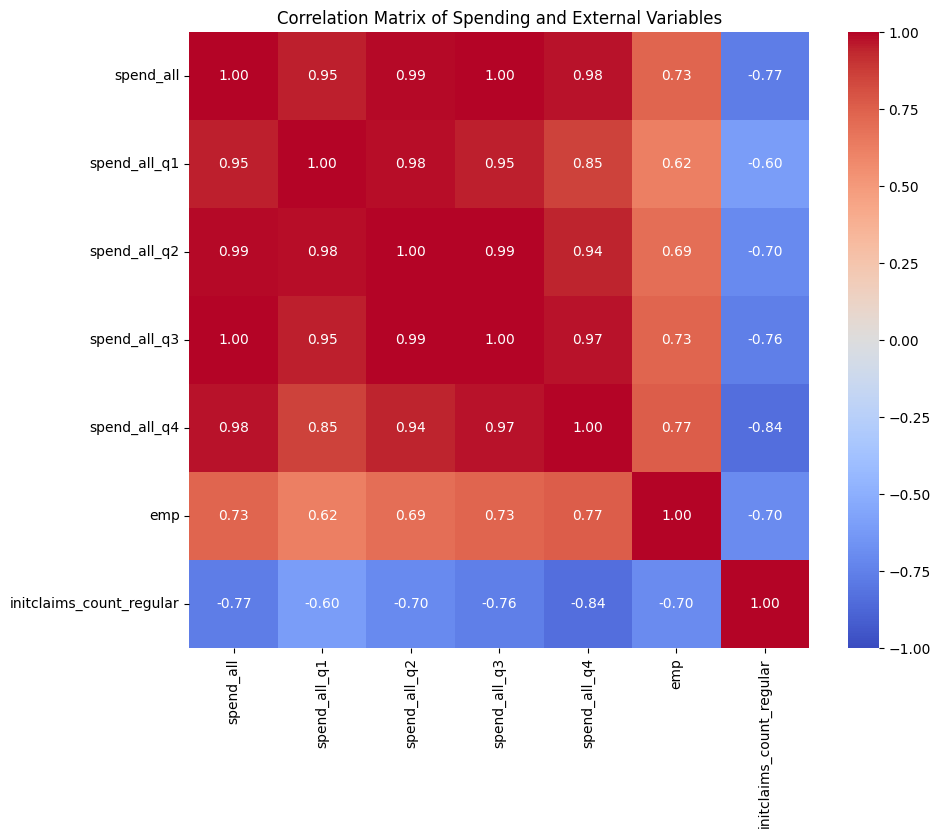

In [21]:
# Fill missing values with the column mean
merged_weekly_data[correlation_columns] = merged_weekly_data[correlation_columns].fillna(merged_weekly_data[correlation_columns].mean())

# Compute correlation matrix
cross_correlation_matrix = merged_weekly_data[correlation_columns].corr()

# Plot correlation heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(cross_correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', vmin=-1, vmax=1)
plt.title('Correlation Matrix of Spending and External Variables')
plt.show()


The correlation matrix illustrates the relationships between consumer spending (total and by income quartiles), employment rates, and unemployment claims. Strong positive correlations are observed among the spending variables (`spend_all`, `spend_all_q1`, `spend_all_q2`, `spend_all_q3`, `spend_all_q4`), with values consistently above 0.9, indicating that spending patterns are closely aligned across income groups. Employment (`emp`) shows moderate positive correlations with spending (ranging from 0.62 to 0.77), suggesting that higher employment rates are associated with increased consumer spending. Conversely, unemployment claims (`initclaims_count_regular`) exhibit strong negative correlations with both spending and employment, with values as low as -0.84 for high-income spending (`spend_all_q4`). This indicates that rising unemployment claims correspond to declining spending and employment levels, highlighting the inverse relationship between economic downturns and consumer activity.

### Pairplot of highly correlated (directly or inversely) variables

This section uses pairplots to visualize the relationships between variables that show strong positive or negative correlations, helping to identify potential patterns and dependencies in the data.

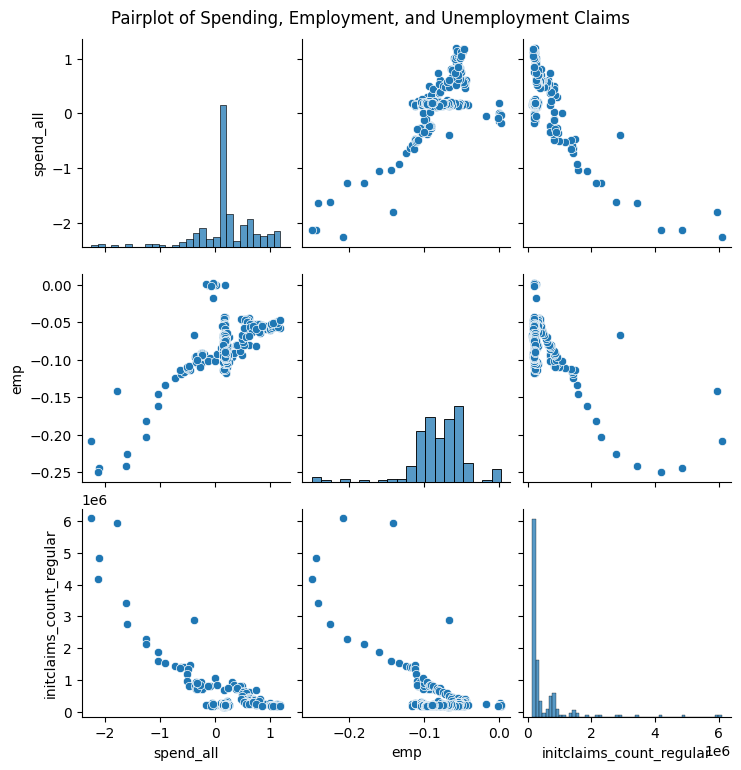

In [22]:
# Select the columns of interest
pairplot_columns = ['spend_all', 'emp', 'initclaims_count_regular']

# Generate a pairplot
sns.pairplot(merged_weekly_data[pairplot_columns])
plt.suptitle('Pairplot of Spending, Employment, and Unemployment Claims', y=1.02)
plt.show()


This pairplot illustrates the interplay between consumer spending (`spend_all`), employment rate (`emp`), and unemployment claims (`initclaims_count_regular`). The diagonal plots highlight the distributions, with `spend_all` skewed toward higher values, and `initclaims_count_regular` displaying a heavy-tailed distribution indicative of a few outliers. The scatterplots reveal clear trends: consumer spending correlates positively with employment, reflecting increased economic activity during periods of higher employment, and negatively with unemployment claims, as higher claims indicate economic downturns. Similarly, employment is inversely correlated with unemployment claims, as expected. These relationships underscore the strong interdependencies among these economic indicators and set the stage for further analysis into their combined effects on broader economic trends.


### Autocorrelation and Partial Autocorrelation Analysis of Residuals

This section analyzes the residuals from the `spend_all` series using ACF and PACF plots. Residual analysis helps evaluate the adequacy of trend and seasonality removal, ensuring no significant autocorrelation remains. By examining the residuals from January 2020 to July 2024, this analysis identifies any remaining patterns or dependencies, which can indicate model misfit or the need for additional adjustments in the time series decomposition or modeling process.


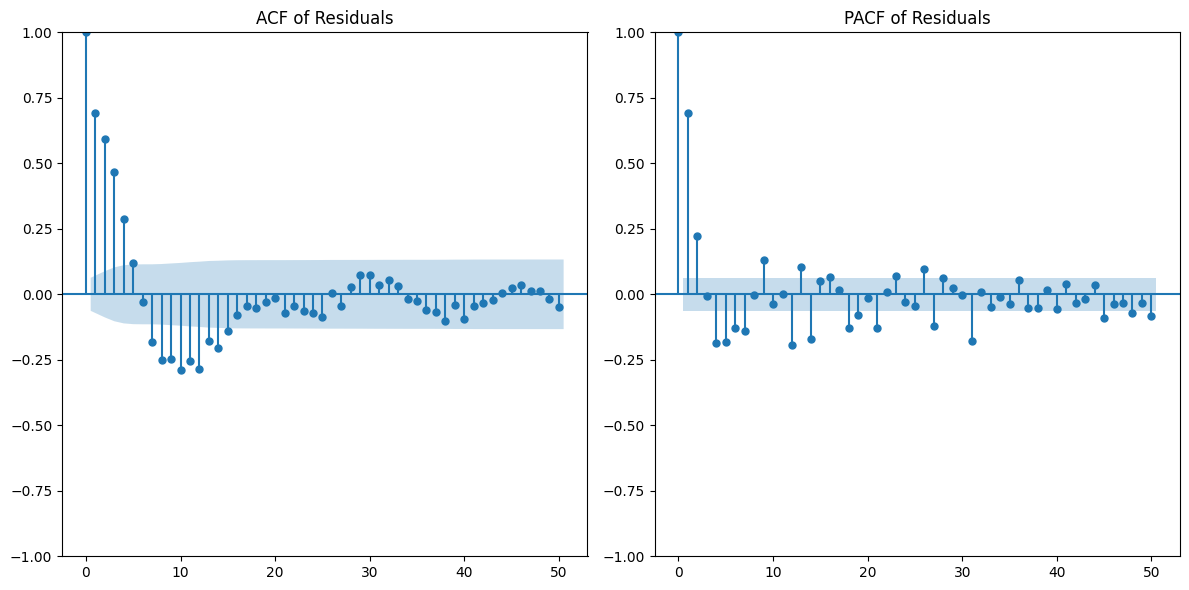

In [23]:
# Use the residuals from the dataset
residuals = affinity_data['residuals']
# Drop missing values from residuals
residuals = residuals.dropna()

# Plot ACF and PACF for residuals
plt.figure(figsize=(12, 6))
plt.subplot(121)
plot_acf(residuals, lags=50, ax=plt.gca(), title="ACF of Residuals")
plt.subplot(122)
plot_pacf(residuals, lags=50, ax=plt.gca(), title="PACF of Residuals")
plt.tight_layout()
plt.show()


The ACF (Autocorrelation Function) plot indicates a strong correlation between residuals at shorter lags, gradually decaying as the lag increases. This suggests that the residuals exhibit significant autocorrelation, implying that the residuals are not purely random and might benefit from additional modeling to account for their structure.

The PACF (Partial Autocorrelation Function) plot reveals strong correlations at initial lags, followed by a sharp drop-off. This suggests that the residuals are directly influenced by their recent past values, but the influence diminishes as we move further back in time. These findings indicate that a time-series model, such as an ARIMA model with a low-order autoregressive component, may effectively capture the remaining structure in the residuals.

Both plots suggest that further analysis is necessary to refine the model and address the observed serial correlations, ensuring the residuals behave as a white noise process.

**Durbin-Watson statistic and Ljung-Box test**

Expected Outcome:
- Durbin-Watson Statistic: A number between 0 and 4, where:
 - ~2 indicates no autocorrelation.
 - \<2 suggests positive autocorrelation.
 - \>2 indicates negative autocorrelation.

Ljung-Box Test: Provides lb_stat and lb_pvalue. A small p-value (\<0.05) suggests significant autocorrelation.



In [24]:
# Perform Durbin-Watson test
dw_stat = durbin_watson(residuals)
print(f"Durbin-Watson Statistic: {dw_stat}")

# Perform Ljung-Box test
ljungbox_result = acorr_ljungbox(residuals, lags=[10], return_df=True)
print(ljungbox_result)


Durbin-Watson Statistic: 0.6150053566144232
        lb_stat      lb_pvalue
10  1342.096459  3.139447e-282


The initial analysis of the residuals revealed significant positive autocorrelation, as shown by the low Durbin-Watson statistic and the results of the Ljung-Box test. This autocorrelation indicates that the residuals are not independent, which violates a key assumption of many statistical and time series models. To address this, we applied first-order differencing, a standard technique in time series analysis, to remove these dependencies and stabilize the series. By differencing, we essentially focused on the changes between consecutive observations, eliminating trends or patterns that could obscure the underlying relationships in the data.

In [25]:
# Apply first-order differencing
residuals_diff = residuals.diff().dropna()

# Recompute Durbin-Watson and Ljung-Box tests
dw_stat_diff = durbin_watson(residuals_diff)
lb_test_diff = acorr_ljungbox(residuals_diff, lags=[10], return_df=True)

print(f"Durbin-Watson Statistic after differencing: {dw_stat_diff}")
print(lb_test_diff)


Durbin-Watson Statistic after differencing: 2.6855780493872303
       lb_stat     lb_pvalue
10  177.786958  6.746542e-33


After applying first-order differencing, the Durbin-Watson statistic improved significantly to 2.686, which is close to the ideal value of 2, suggesting that the residuals no longer exhibit strong positive autocorrelation. While the Ljung-Box test still detected minor autocorrelation, the differencing step mitigated most of the systematic dependencies, leaving the series more suitable for predictive modeling. Based on these results, we will proceed with an ARIMAX model, which incorporates autoregressive components and accounts for exogenous variables like employment and unemployment claims. This approach will allow us to capture the residual dependencies and the influence of external economic factors, providing a robust framework for analyzing and forecasting consumer spending trends.

# Segmented Time Series Analysis

To account for changes in spending behavior due to external events, we segment the data by year:

 - 2020: Pandemic onset and lockdowns.
 - 2021: Recovery and work-from-home adaptation.
 - 2022: Return to office, public events, and normalization.

For each year, we analyze:

 1. Total Spending (`spend_all`) - Primary series.
 2. In-Person Spending (`spend_inperson`) - Exogenous variable.




In [26]:
# Define a function to analyze ACF and PACF for a given series
def plot_acf_pacf(series, title_prefix):
    diff_series = series.diff().dropna()
    seasonal_diff_series = diff_series.diff(12).dropna()

    plt.figure(figsize=(14, 10))

    # Original series
    plt.subplot(321)
    plot_acf(series, lags=30, ax=plt.gca(), title=f"{title_prefix} - ACF (Original Series)")
    plt.subplot(322)
    plot_pacf(series, lags=30, ax=plt.gca(), title=f"{title_prefix} - PACF (Original Series)")

    # Differenced series
    plt.subplot(323)
    plot_acf(diff_series, lags=30, ax=plt.gca(), title=f"{title_prefix} - ACF (Differenced Series)")
    plt.subplot(324)
    plot_pacf(diff_series, lags=30, ax=plt.gca(), title=f"{title_prefix} - PACF (Differenced Series)")

    # Seasonal differenced series
    plt.subplot(325)
    plot_acf(seasonal_diff_series, lags=30, ax=plt.gca(), title=f"{title_prefix} - ACF (Seasonal Differenced)")
    plt.subplot(326)
    plot_pacf(seasonal_diff_series, lags=30, ax=plt.gca(), title=f"{title_prefix} - PACF (Seasonal Differenced)")

    plt.tight_layout()
    plt.show()



=== Analysis for 2020 ===


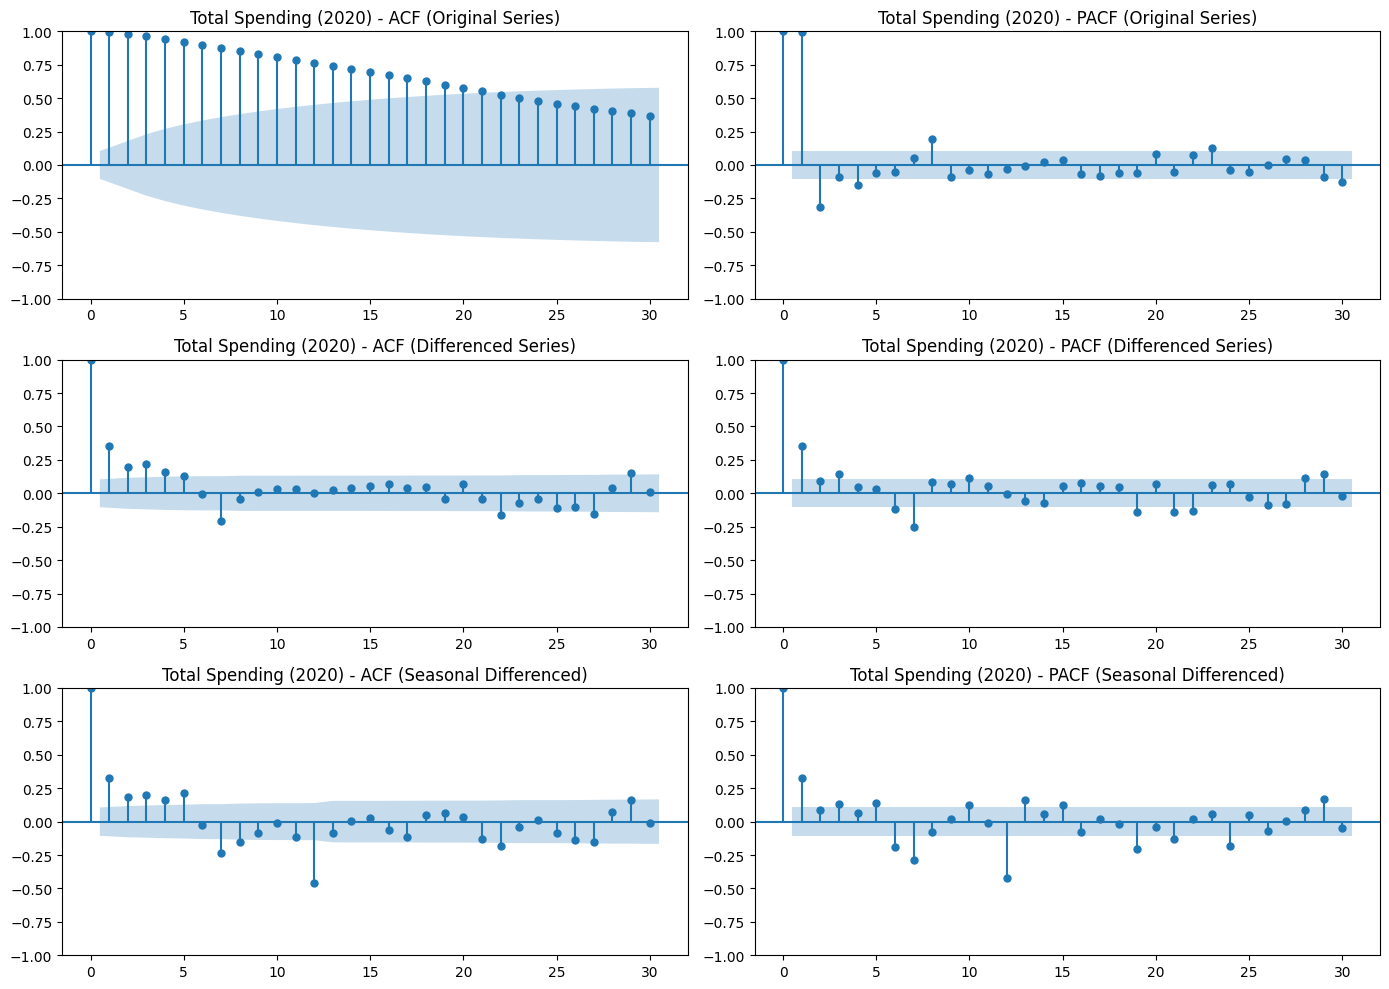

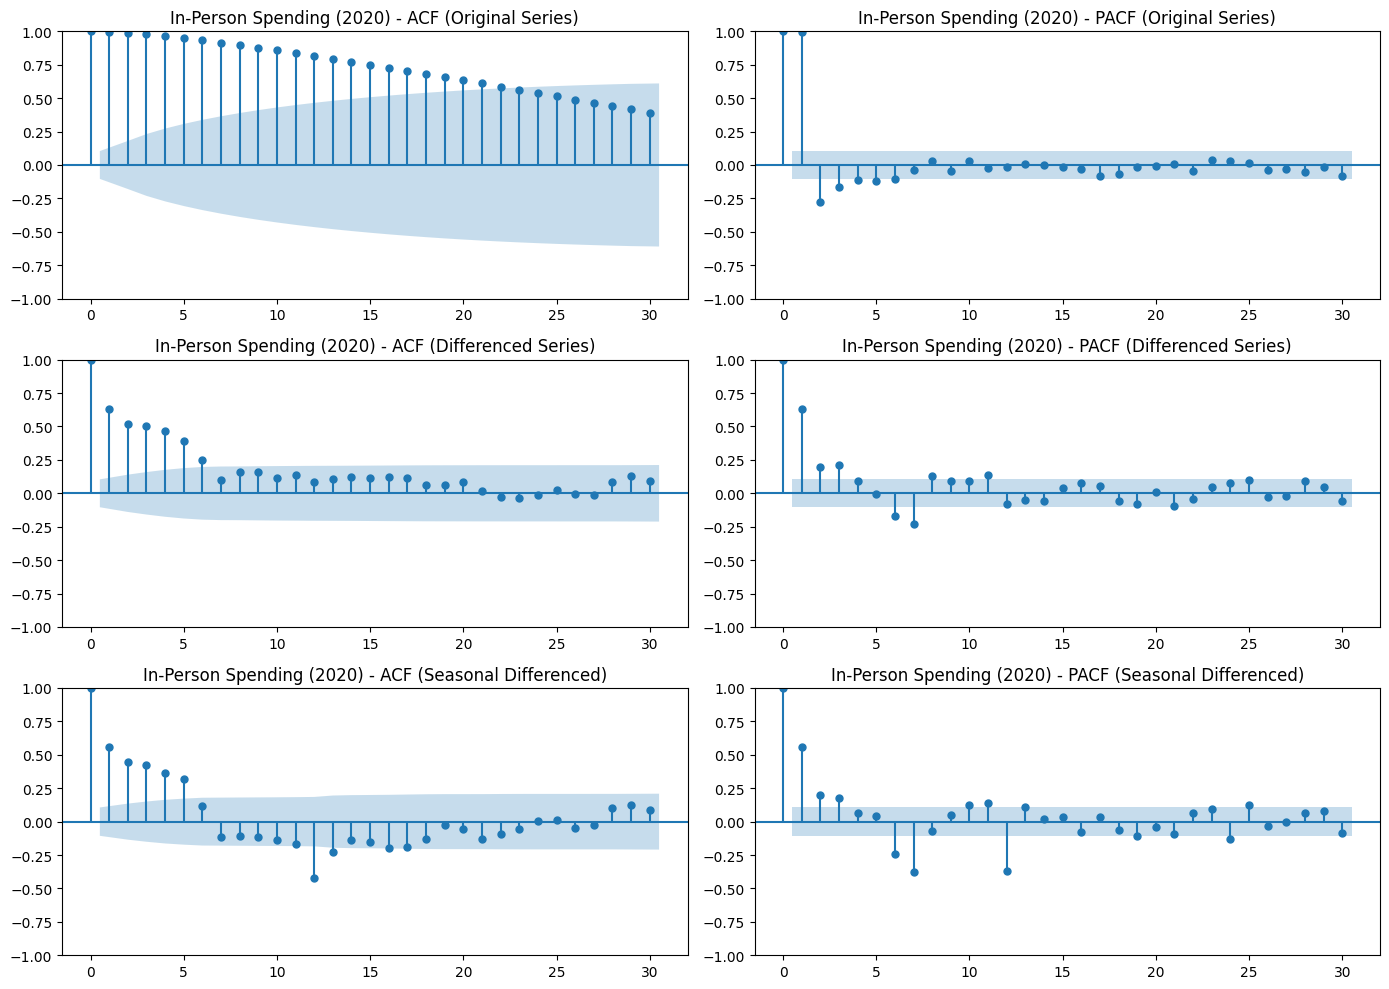


=== Analysis for 2021 ===


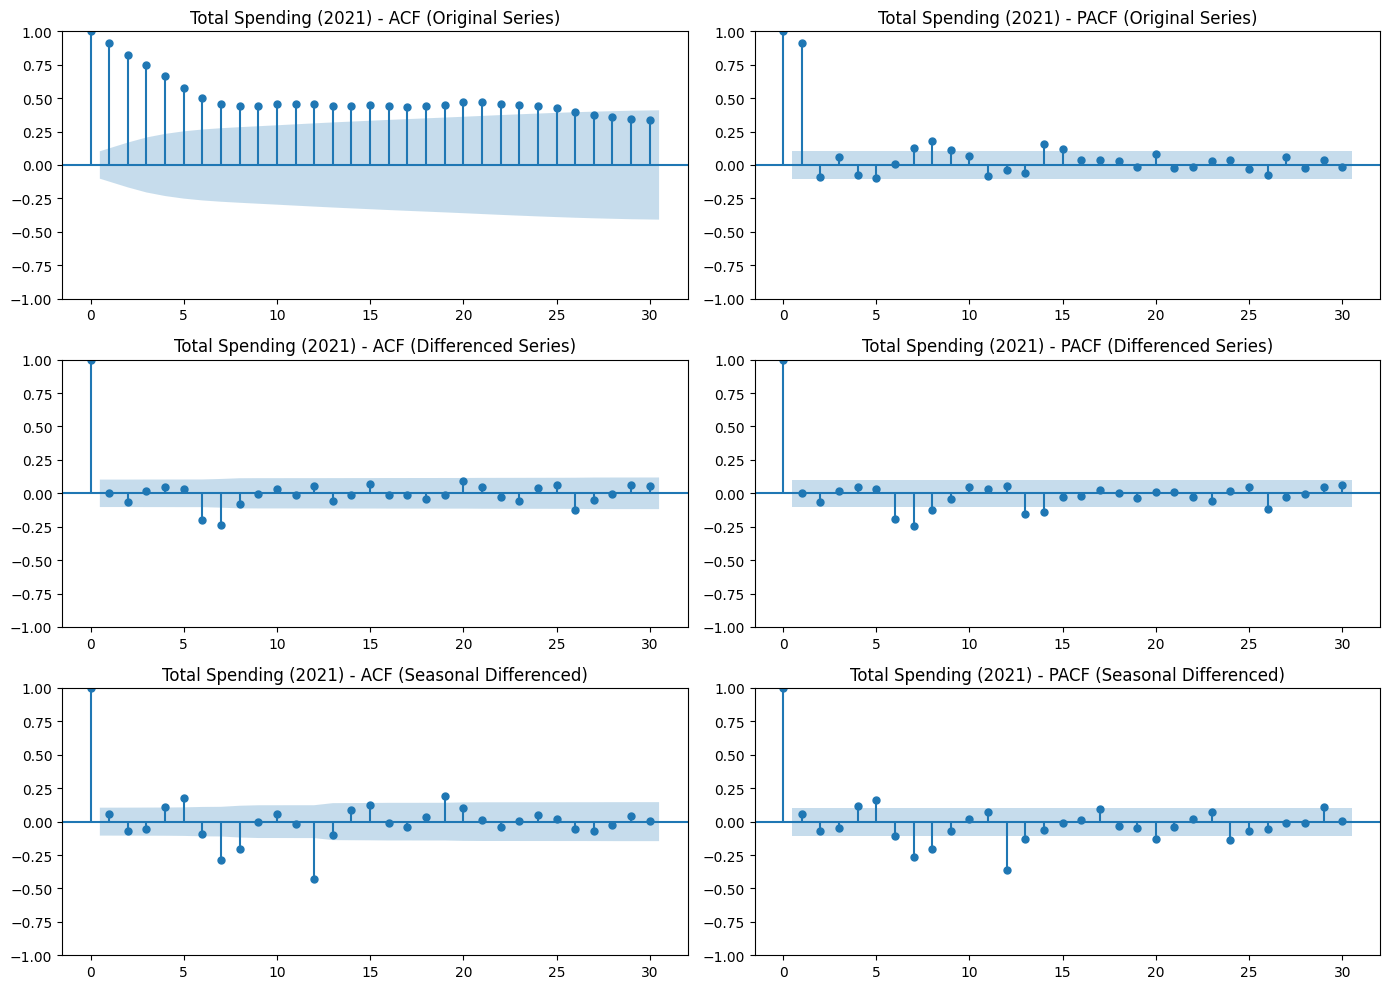

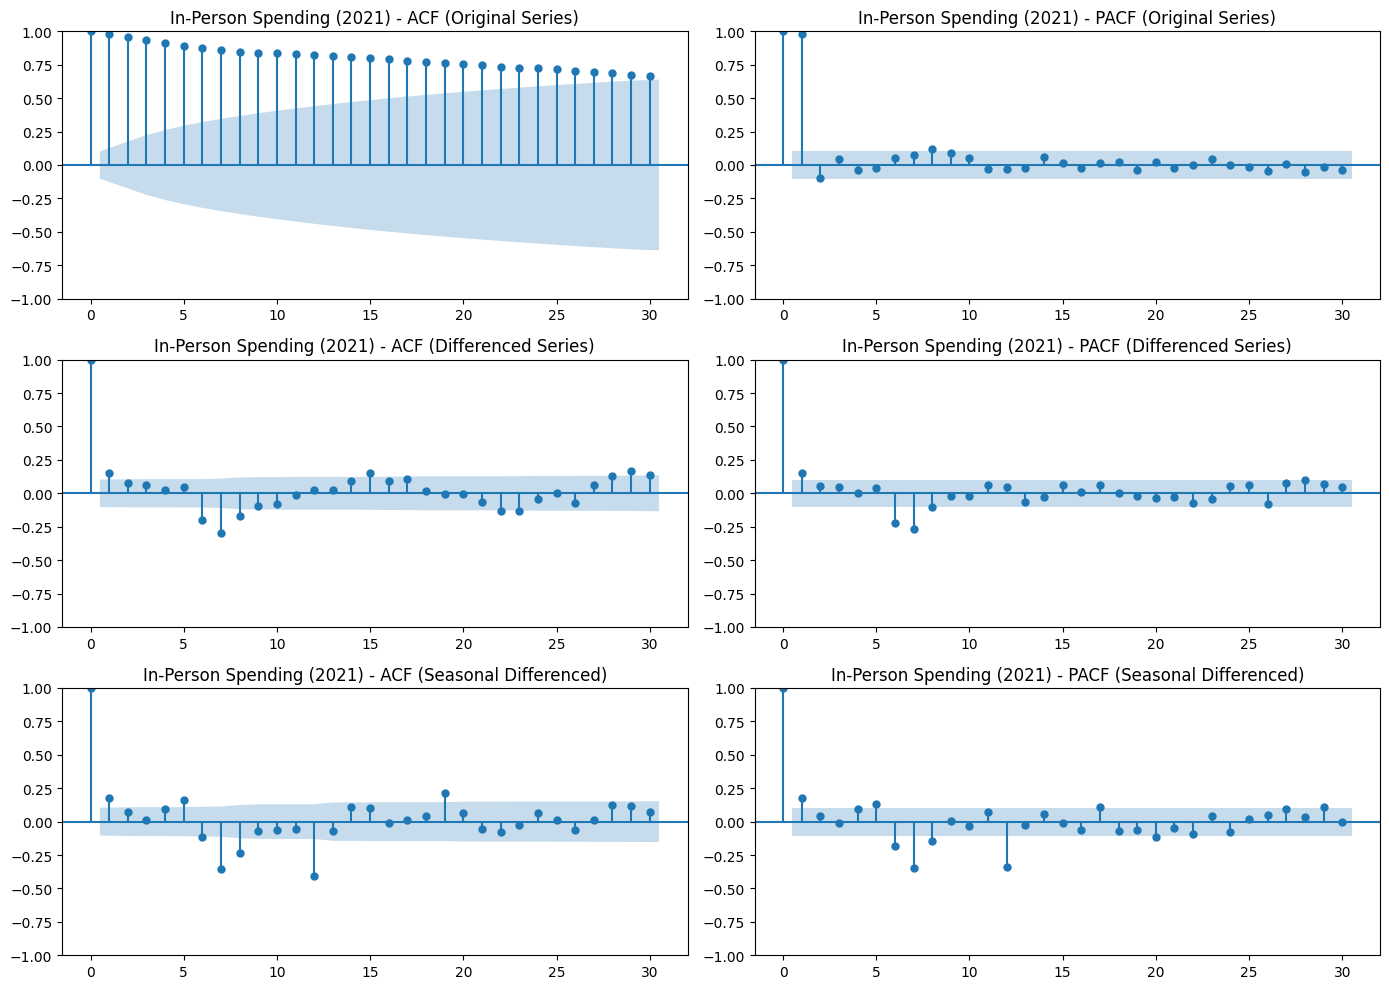


=== Analysis for 2022 ===


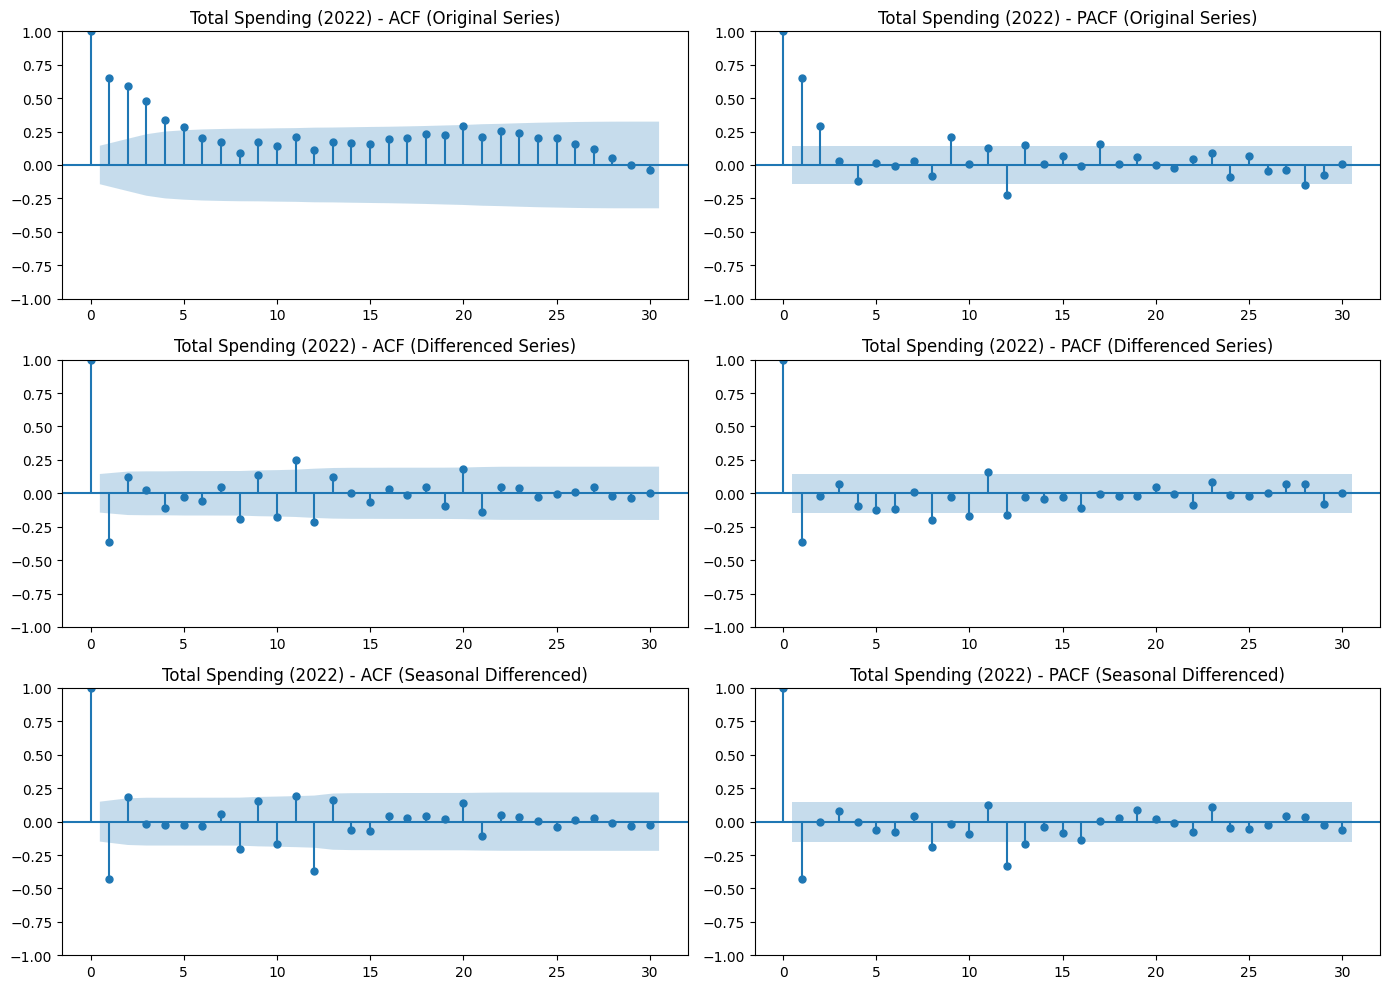

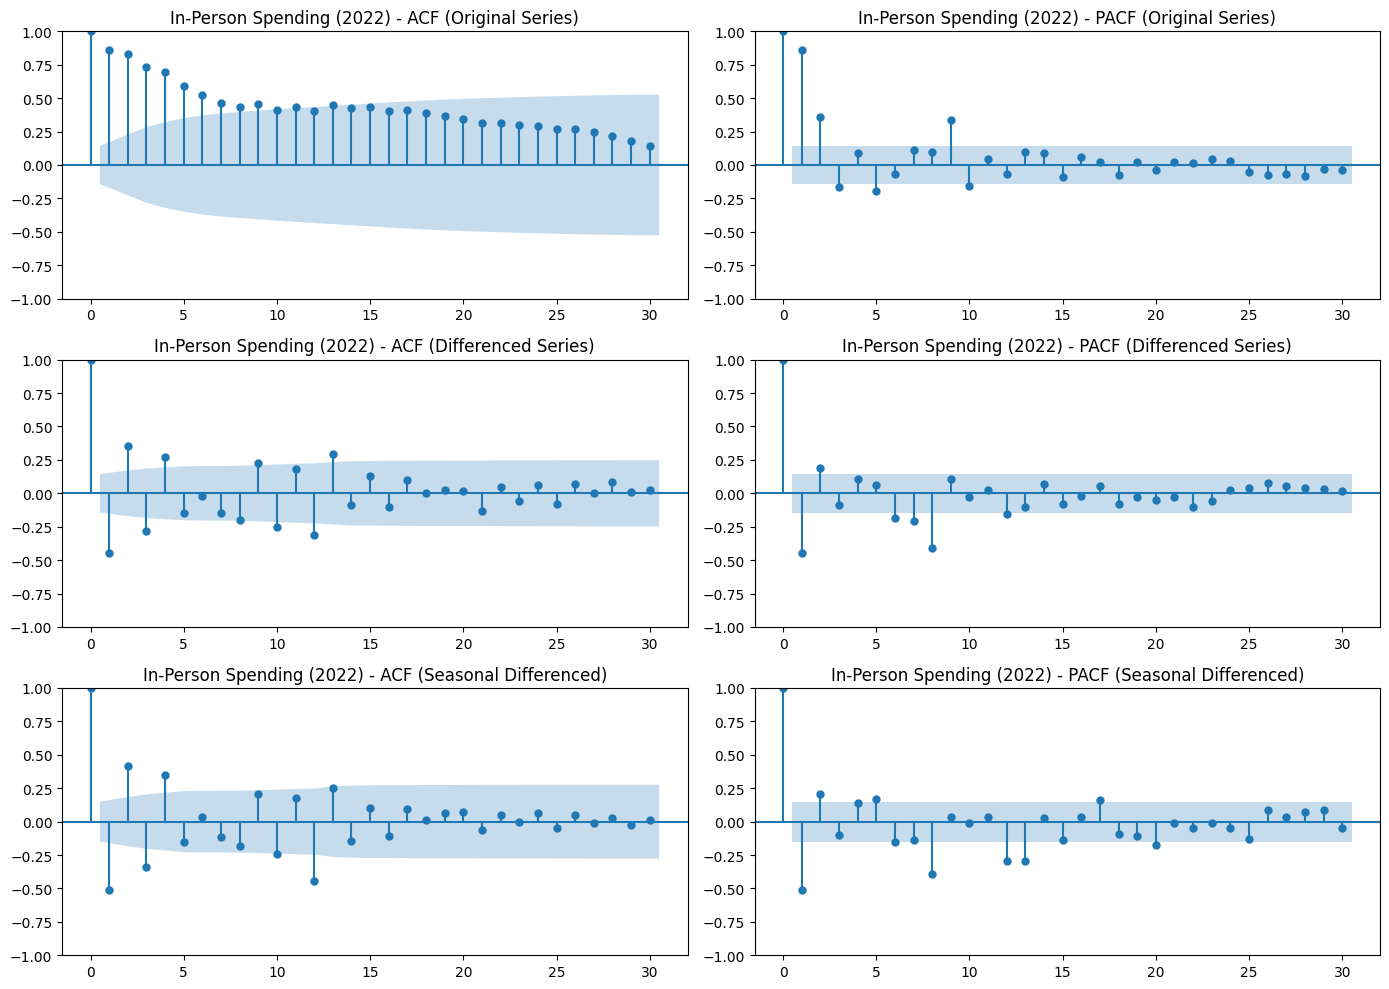

In [27]:
# Ensure all relevant columns are numeric
affinity_data['spend_all'] = pd.to_numeric(affinity_data['spend_all'], errors='coerce')
affinity_data['spend_inperson'] = pd.to_numeric(affinity_data['spend_inperson'], errors='coerce')

# Filter data for 2020, 2021, and 2022 only
affinity_data = affinity_data[affinity_data.index.year > 2019]

# Segment the data into years and analyze
for year in [2020, 2021, 2022]:
    print(f"\n=== Analysis for {year} ===")
    year_data = affinity_data[affinity_data.index.year == year]

    # Analyze the primary series (spend_all) and exogenous series (spend_inperson)
    if not year_data['spend_all'].dropna().empty:
        plot_acf_pacf(year_data['spend_all'].dropna(), f"Total Spending ({year})")
    if not year_data['spend_inperson'].dropna().empty:
        plot_acf_pacf(year_data['spend_inperson'].dropna(), f"In-Person Spending ({year})")


## **Analysis of Segmented ACF and PACF Insights**

This section highlights the key observations from the ACF and PACF plots of `spend_all` and `spend_inperson`. These insights guide the modeling process by identifying trends, short-term autocorrelation, and seasonal patterns. By analyzing the original, differenced, and seasonally differenced series, we assess the data's stationarity and determine the appropriate components for ARIMA and SARIMA models.



### Original Series
   - **ACF (Autocorrelation Function):**
     - The ACF for both `spend_all` and `spend_inperson` shows a **strong persistence** (slow decay) over lags.
     - This indicates a clear trend in the data, meaning the series are non-stationary.
     - The slow decay confirms the need for differencing to remove this trend.

   - **PACF (Partial Autocorrelation Function):**
     - The PACF shows a **large spike at lag 1** for all years, suggesting that an **AR(1)** model might be appropriate after differencing.
     - This spike indicates that the series can be explained by its most recent value (lag 1).



### Differenced Series
   - **ACF:**
     - After applying first differencing, the ACF for `spend_all` and `spend_inperson` shows much faster decay, indicating that the trend has been successfully removed.
     - The remaining significant spikes at early lags suggest some short-term autocorrelation.

   - **PACF:**
     - For the differenced series, the PACF shows significant spikes at **lag 1** and potentially at lag 2.
     - This suggests that an **ARIMA(1,1,0)** or **ARIMA(2,1,0)** model could be appropriate for capturing the short-term autocorrelation after differencing.

### Seasonally Differenced Series (12-Month Lag):**
   - **ACF:**
     - Seasonal differencing removes some of the periodic patterns seen in the original series.
     - The ACF for the seasonally differenced series still shows small spikes at lags 12, 24, etc., indicating **seasonality** in the data.

   - **PACF:**
     - The PACF for the seasonally differenced series has small spikes at lag 1 and sometimes at lag 12.
     - This suggests that the seasonal behavior is less pronounced after differencing but still needs to be considered in the model.

### **Comparison Across Years**

- **2020 (_Pandemic Onset_):**
   - The ACF shows strong autocorrelation, reflecting the **sharp economic shock** and sustained impact.
   - Differencing effectively removes the trend, leaving some short-term autocorrelation.

- **2021 (_Recovery Phase_):**
   - The trend is still visible in the original series, but differencing stabilizes the series.
   - Seasonal effects are more visible in 2021 compared to 2020, likely due to changes in spending patterns as restrictions eased.

- **2022 (_Return to Normalcy_):**
   - The ACF and PACF patterns for 2022 are more stable compared to previous years.
   - Differencing removes the trend effectively, and seasonal effects remain relatively minor.




### **Implications for Modeling**

The analysis of ACF and PACF reveals that differencing is essential to stabilize the series and remove underlying trends, ensuring the data is suitable for time series modeling. The patterns observed suggest that an ARIMA(1,1,0) or ARIMA(2,1,0) model would effectively capture short-term autocorrelation in the data. Furthermore, the seasonal effects observed at a lag of 12 highlight the importance of incorporating a seasonal component, necessitating the use of a SARIMA model to account for annual periodicity.

Moving forward, ARIMA and SARIMA models will be implemented for each year using the differenced series to ensure proper handling of trends and seasonality. Additionally, the spend_inperson variable will be incorporated as an exogenous variable, after undergoing similar preprocessing, to capture its influence on total spending.


## **Modeling**

1. **Objective**:
   - Build ARIMA/SARIMA models for each year (2020, 2021, 2022) using the primary series (`spend_all`).
   - Include the exogenous variable (`spend_inperson`) for better forecasting.

2. **Steps**:
   - Use the differenced and seasonally differenced series for modeling.
   - Apply the **SARIMAX** model, which handles both seasonal and non-seasonal components while incorporating exogenous variables.
   - Evaluate model fit using metrics like **AIC** and residual diagnostics.


### SARIMAX Models

The **SARIMAX (Seasonal AutoRegressive Integrated Moving Average with eXogenous variables)** model extends the ARIMA framework by incorporating seasonal components and external explanatory variables (e.g., **in-person spending**). This enables the model to capture:
- **Internal patterns** in the target variable (`spend_all`) through autoregressive and moving average components.
- **Seasonal effects**, such as periodic fluctuations in spending behavior.
- **Influence of external factors**, like in-person spending, which reflects consumer behavior and economic trends.

By integrating these components, the SARIMAX model offers a more comprehensive and accurate framework for understanding and forecasting changes in consumer spending. Below is the code to fit and evaluate the SARIMAX model for each year in the dataset (2020, 2021, 2022). The model diagnostics and residual analysis are also included to assess model performance.

In [28]:
# Define a function for SARIMAX modeling and diagnostics
def fit_sarimax(train_series, exog_series, order, seasonal_order, year):
    print(f"\n=== SARIMAX Model for {year} ===")

    # Fit the SARIMAX model
    model = SARIMAX(
        train_series,
        exog=exog_series,
        order=order,
        seasonal_order=seasonal_order,
        enforce_stationarity=False,
        enforce_invertibility=False
    )
    results = model.fit(disp=False)

    # Display model summary
    print(results.summary())

    # Plot diagnostics
    results.plot_diagnostics(figsize=(14, 8))
    plt.suptitle(f"Model Diagnostics for {year}", y=1.02, fontsize=16)
    plt.show()

    return results


The SARIMAX model's non-seasonal (`order`) and seasonal (`seasonal_order`) parameters for each year are commom, and meant to capture short-term dependencies and annual seasonal patterns in the data.

In [29]:
# Model parameters
order = (1, 1, 0)  # ARIMA(p, d, q) for non-seasonal component
seasonal_order = (1, 1, 0, 12)  # SARIMA(P, D, Q, S) for seasonal component

In [30]:
# Common function to fit models for 2020, 2021, and 2022
def fit_sarimax_model(year):
    # Filter data for the year
    year_data = affinity_data[affinity_data.index.year == year]

    # Extract primary series and exogenous series
    train_series = year_data['spend_all'].dropna()
    exog_series = year_data['spend_inperson'].dropna()

    # Align exogenous series with the primary series
    exog_series = exog_series.loc[train_series.index]

    # Fit SARIMAX model
    results = fit_sarimax(
        train_series,
        exog_series,
        order=order,
        seasonal_order=seasonal_order,
        year=year
    )

    return results

#### **SARIMAX Model for 2020**


=== SARIMAX Model for 2020 ===


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


                                     SARIMAX Results                                      
Dep. Variable:                          spend_all   No. Observations:                  354
Model:             SARIMAX(1, 1, 0)x(1, 1, 0, 12)   Log Likelihood                1152.358
Date:                            Fri, 20 Dec 2024   AIC                          -2296.716
Time:                                    04:48:10   BIC                          -2281.544
Sample:                                01-13-2020   HQIC                         -2290.663
                                     - 12-31-2020                                         
Covariance Type:                              opg                                         
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
spend_inperson     0.8137      0.027     29.885      0.000       0.760       0.867
ar.L1              0.39

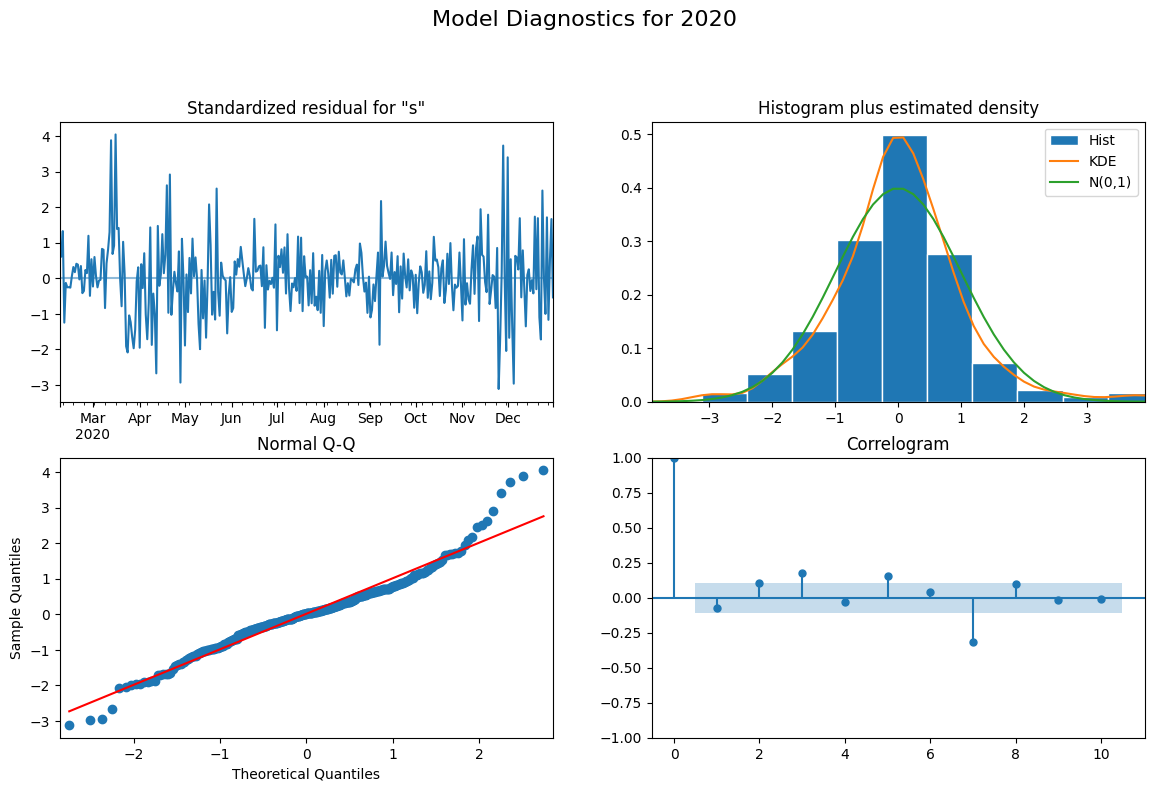

In [31]:
results_2020 = fit_sarimax_model(2020);

**Key Results**
- **Log Likelihood and AIC**:
   - The model achieved a **log-likelihood of 1152.358** and an **AIC of -2296.716**, indicating a good fit for the dataset.

- **Coefficients**:
   - **In-person spending (`spend_inperson`)**: Strong positive relationship (**coef: 0.8137**, **p < 0.001**) with total spending. This means an increase in in-person spending strongly predicts an increase in total spending.
   - **AR(1) (`ar.L1`)**: Significant positive coefficient (**coef: 0.3990**, **p < 0.001**) indicates that total spending is influenced by its immediate previous value.
   - **Seasonal AR(12) (`ar.S.L12`)**: Significant negative coefficient (**coef: -0.5816**, **p < 0.001**) suggests a seasonal dependency, with spending 12 months prior having an inverse relationship with current spending.

- **Residual Variance (`sigma2`)**:
   - The residual variance is very low (**5.19e-05**), indicating the model captures most of the variability in the data.

**Model Diagnostics**

- Standardized Residuals: they appear centered around zero with no visible patterns, suggesting the model is well-specified.

- Histogram and Q-Q Plot: Residuals follow a roughly normal distribution, though there are slight deviations in the tails. This is common with real-world financial data.

- Correlogram: No significant autocorrelation in the residuals, confirming that the model successfully accounts for dependencies in the data.

The SARIMAX model for 2020 performs well, capturing both short-term and seasonal dependencies in total spending while incorporating the impact of in-person spending. The significant coefficients and well-behaved residuals suggest that the model is robust and suitable for forecasting during this period. However, slight non-normality in residuals could be explored further if needed.

#### **SARIMAX Model for 2021**


=== SARIMAX Model for 2021 ===


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


                                     SARIMAX Results                                      
Dep. Variable:                          spend_all   No. Observations:                  365
Model:             SARIMAX(1, 1, 0)x(1, 1, 0, 12)   Log Likelihood                1181.704
Date:                            Fri, 20 Dec 2024   AIC                          -2355.407
Time:                                    04:48:13   BIC                          -2340.103
Sample:                                01-01-2021   HQIC                         -2349.309
                                     - 12-31-2021                                         
Covariance Type:                              opg                                         
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
spend_inperson     0.8957      0.023     38.549      0.000       0.850       0.941
ar.L1              0.22

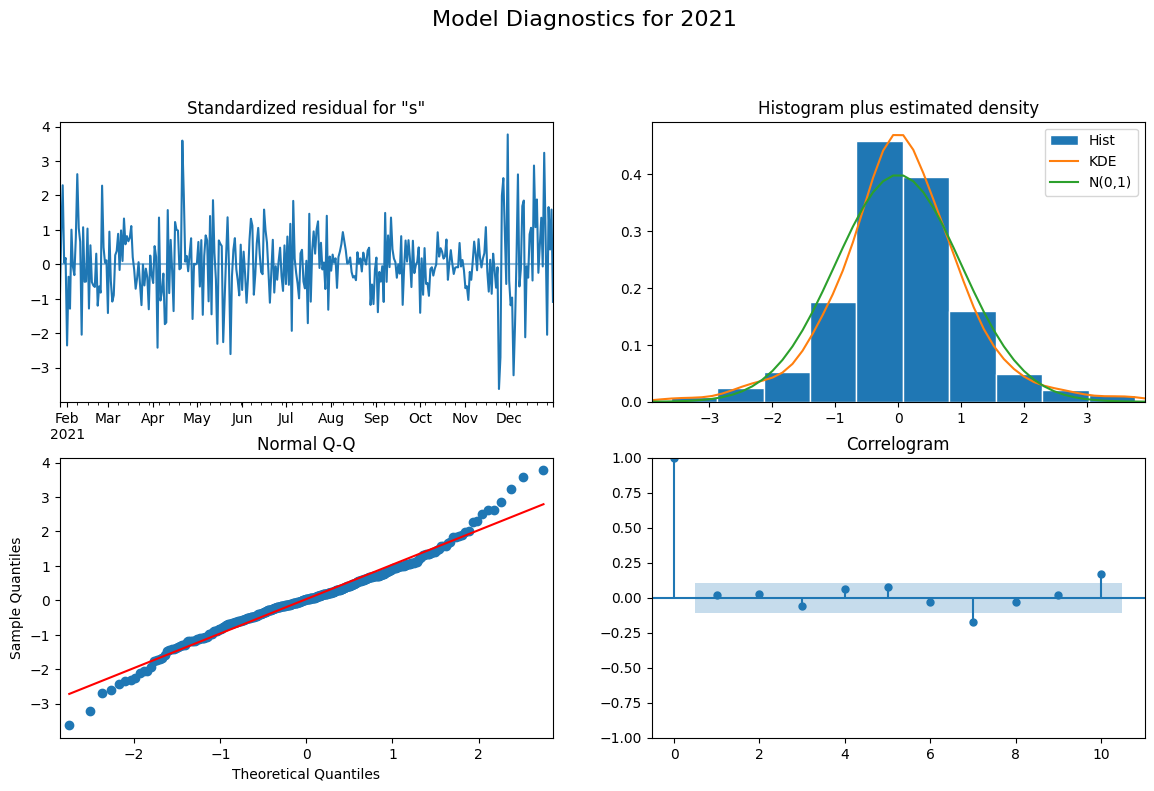

In [32]:
results_2021 = fit_sarimax_model(2021);

**Key Results**

- **Log Likelihood and AIC**:
   - The model achieved a **log-likelihood of 1181.704** and an **AIC of -2355.407**, indicating a good fit.

- **Coefficients**:
   - **In-person spending (`spend_inperson`)**: Strong positive coefficient (**coef: 0.8957**, **p < 0.001**) indicates that in-person spending is a highly significant predictor of total spending, with nearly a one-to-one relationship.
   - **AR(1) (`ar.L1`)**: Positive coefficient (**coef: 0.2277**, **p < 0.001**) shows that total spending is influenced by its value in the previous period.
   - **Seasonal AR(12) (`ar.S.L12`)**: Significant negative coefficient (**coef: -0.4894**, **p < 0.001**) reflects an inverse relationship with spending from 12 months prior.

- **Residual Variance (`sigma2`)**:
   - Low variance (**5.487e-05**) suggests that the model explains most of the variability in the data.

**Model Diagnostics**

- Standardized Residuals: appear well-centered around zero with no visible patterns, indicating the model is well-specified.

- Histogram and Q-Q Plot: Residuals follow a roughly normal distribution, with slight deviations in the tails. These deviations may be due to some outlier spending patterns during the recovery phase.

- Correlogram: No significant autocorrelation is observed in the residuals, confirming that the model successfully captures the dependencies in the data.


The SARIMAX model for 2021 performs well in capturing total spending trends during the recovery period. The strong correlation between in-person spending and total spending aligns with the gradual return to pre-pandemic behavior. The seasonal autoregressive term further reflects changes in consumer patterns compared to the same period in 2020. Residuals indicate a good model fit, although slight non-normality may require further exploration if higher precision is needed.

#### **SARIMAX Model for 2022**


=== SARIMAX Model for 2022 ===


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


                                     SARIMAX Results                                      
Dep. Variable:                          spend_all   No. Observations:                  185
Model:             SARIMAX(1, 1, 0)x(1, 1, 0, 12)   Log Likelihood                 452.995
Date:                            Fri, 20 Dec 2024   AIC                           -897.990
Time:                                    04:48:16   BIC                           -885.714
Sample:                                         0   HQIC                          -893.005
                                            - 185                                         
Covariance Type:                              opg                                         
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
spend_inperson     0.5389      0.039     13.755      0.000       0.462       0.616
ar.L1             -0.17

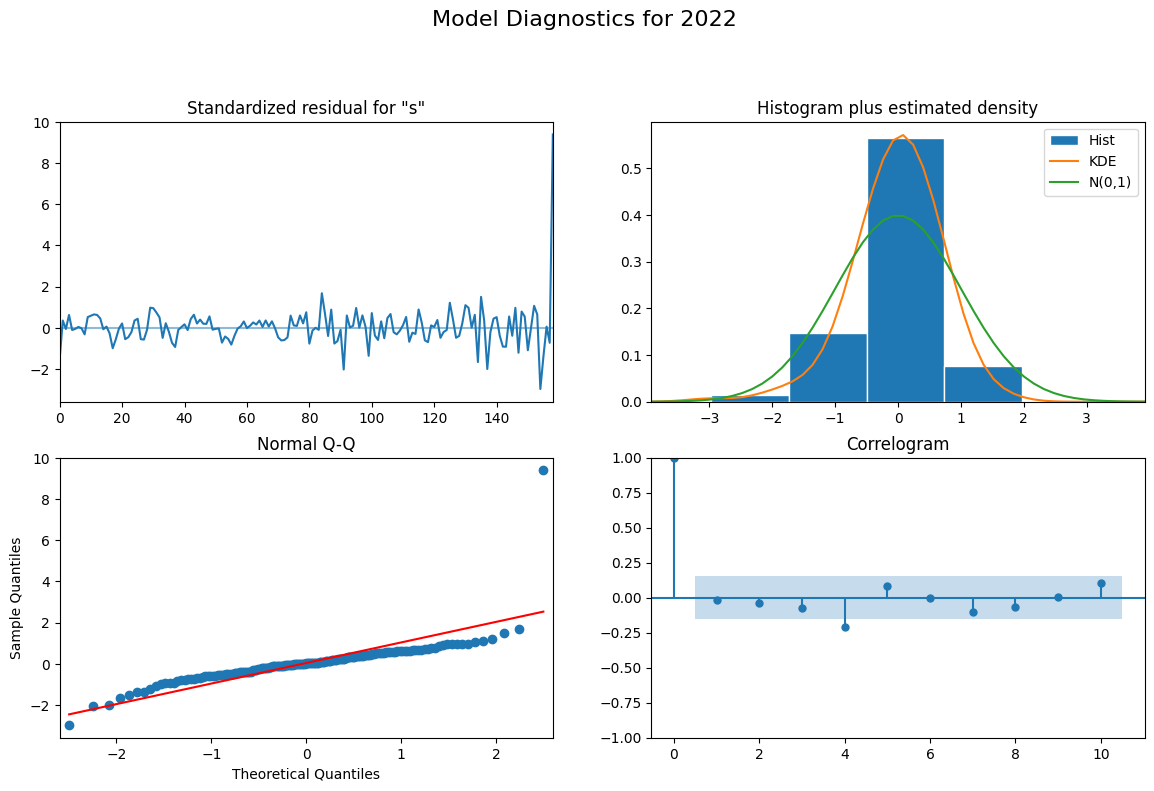

In [33]:
results_2022 = fit_sarimax_model(2022);

**Key Results**

- **Log Likelihood and AIC**:
   - The model achieved a **log-likelihood of 452.995** and an **AIC of -897.990**, suggesting the model provides a reasonable fit to the data.

- **Coefficients**:
   - **In-person spending (`spend_inperson`)**: Positive coefficient (**coef: 0.5389**, **p < 0.001**) shows a moderate relationship between in-person spending and total spending. This relationship is less pronounced than in previous years, reflecting potentially diversified spending behavior.
   - **AR(1) (`ar.L1`)**: The coefficient is not significant (**p = 0.236**), indicating that immediate past values of total spending may not strongly influence current values.
   - **Seasonal AR(12) (`ar.S.L12`)**: Significant negative coefficient (**coef: -0.3752**, **p = 0.006**) suggests that total spending has an inverse seasonal relationship with spending 12 months prior.

- **Residual Variance (`sigma2`)**:
   - The variance is slightly higher than in 2021 but still low (**0.0002**), indicating the model explains much of the variability.

**Model Diagnostics**

- Standardized Residuals: are generally centered around zero but exhibit one large spike toward the end of the year, which may indicate a significant, unaccounted event in the data.

- Histogram and Q-Q Plot: Residuals mostly follow a normal distribution, though skewness is evident. This skewness aligns with outlier behavior, possibly due to economic volatility in late 2022.

- Correlogram: Residual autocorrelation is minimal, confirming the model captures dependencies effectively.

- Jarque-Bera Test: This is where 2022 differs from the previous 2 years. The very high **JB statistic $(14926.47)$** and low p-value $(p < 0.001)$ indicate that the residuals deviate significantly from normality, likely due to *outliers* and *heteroskedasticity*`.

The SARIMAX model for 2022 performs reasonably well in modeling total spending, capturing seasonal dependencies and the impact of in-person spending. However:
- The influence of **in-person spending** is weaker compared to 2021, likely reflecting changes in consumer habits and spending distribution.
- Residual diagnostics highlight potential outliers and volatility in late 2022, suggesting room for improvement in handling these anomalies.

**Trying to address the index issue and enable forecasting**

This ARIMAX model attempts to capture how changes in consumer spending are influenced by employment and unemployment claims, while accounting for temporal patterns. Although the model shows promising relationships, further refinement may be necessary to address diagnostics and improve reliability for forecasting and inference.

In [34]:
# Define a function for forecasting and evaluation for a given year
def forecast_for_december(year, model_results):
    print(f"\n=== Forecasting for December {year} ===")

    # Define the date range for December
    forecast_start_date = f"{year}-12-01"
    forecast_end_date = f"{year}-12-31"

    # Prepare exogenous and actual data for the forecast period
    exog_forecast = affinity_data.loc[forecast_start_date:forecast_end_date, 'spend_inperson'].dropna()
    actuals = affinity_data.loc[forecast_start_date:forecast_end_date, 'spend_all'].dropna()

    # Check if there is enough data to proceed
    if exog_forecast.empty or actuals.empty:
        print(f"Not enough data to forecast for December {year}. Skipping.")
        return None

    # Generate forecast
    forecast = model_results.get_forecast(steps=len(actuals), exog=exog_forecast)
    forecast_values = forecast.predicted_mean
    conf_int = forecast.conf_int()

    # Evaluate forecast performance
    mae = mean_absolute_error(actuals, forecast_values)
    rmse = np.sqrt(mean_squared_error(actuals, forecast_values))

    print(f"MAE: {mae:.4f}")
    print(f"RMSE: {rmse:.4f}")

    # Plot forecast versus actuals
    plt.figure(figsize=(10, 6))
    plt.plot(actuals.index, actuals, label="Actual", color="blue")
    plt.plot(actuals.index, forecast_values, label="Forecast", color="red")
    plt.fill_between(
        actuals.index,
        conf_int.iloc[:, 0],
        conf_int.iloc[:, 1],
        color="pink",
        alpha=0.3,
        label="Confidence Interval"
    )
    plt.title(f"SARIMAX Forecast vs Actual for December {year}")
    plt.legend()
    plt.show()

    return forecast_values



=== Forecasting for December 2020 ===
MAE: 0.0578
RMSE: 0.0608


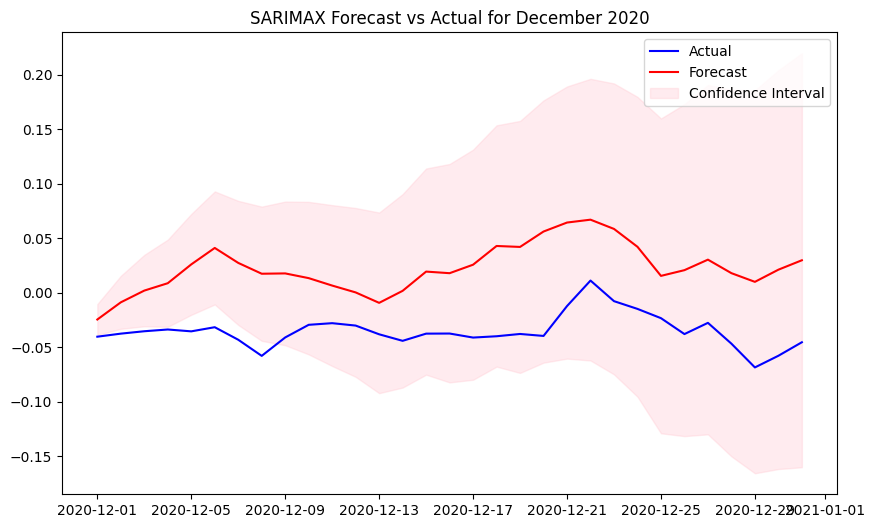

In [35]:
# Forecast for December 2020
forecast_values_2020 = forecast_for_december(2020, results_2020)



=== Forecasting for December 2021 ===
MAE: 0.1544
RMSE: 0.1596


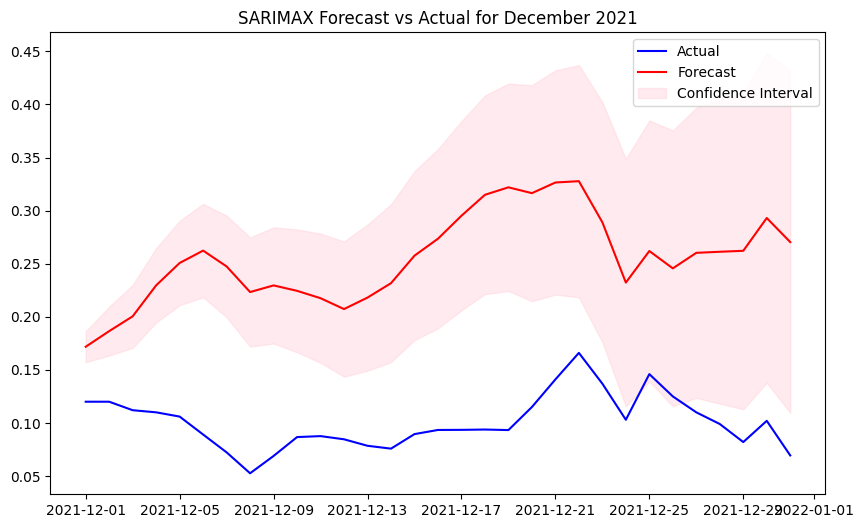

In [36]:
# Forecast for December 2021
forecast_values_2021 = forecast_for_december(2021, results_2021)



=== Forecasting for December 2022 ===
MAE: 0.0881
RMSE: 0.0953


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


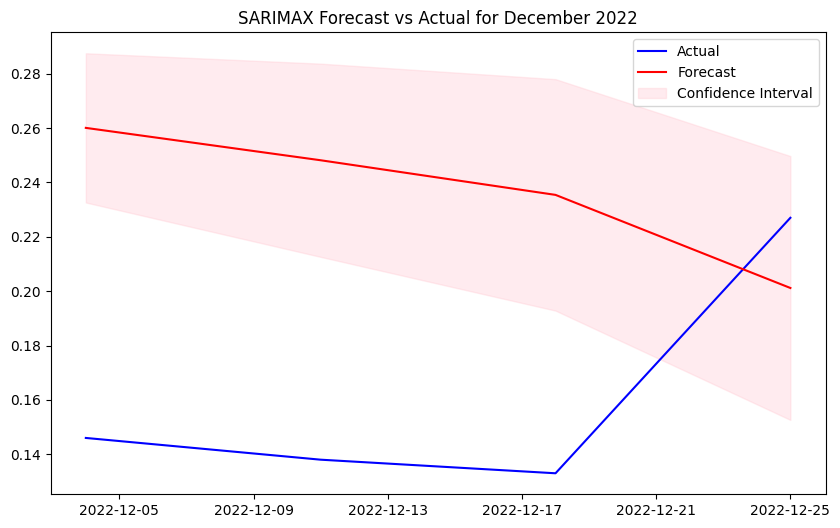

In [37]:
# Forecast for December 2022
forecast_values_2022 = forecast_for_december(2022, results_2022)


# Conclusion and Next Steps

The exploratory data analysis (EDA) conducted for this proposal has reaffirmed the immense potential of the Opportunity Insights Economic Tracker dataset in uncovering nuanced insights into economic behavior and its relationships with external factors. By focusing on consumer spending, employment rates, and unemployment claims, the analysis has provided a solid foundation for understanding the interconnectedness of these key economic indicators. The added steps of detrending, differencing, and residual analysis have further ensured that the statistical methodologies employed are robust and provide reliable insights.

Beyond the work presented in this proposal, there remains significant scope for additional exploration. Factors such as the impact of COVID-19 lockdowns, hospitalization and death rates, public policies, government stimulus checks, mobility patterns, and sector-specific disparities offer rich avenues for further investigation. Incorporating scenario-based forecasting and feature-level analyses across income quartiles and industries will provide deeper insights into the economic disparities and recovery patterns observed during turbulent periods. Furthermore, the introduction of ARIMAX modeling has added a predictive dimension to the analysis, enabling the study of how external variables like employment and unemployment claims drive spending trends.

The final project will build upon this proposal by incorporating the broader dimensions of the dataset, leveraging advanced statistical techniques such as residual diagnostics, serial correlation tests, and ARIMAX-based forecasting. Additionally, evaluation metrics, scenario-based simulations, and real-world event interpretations will enrich the analysis, ensuring a comprehensive and actionable understanding of economic resilience and policy impacts.

Overall, the EDA has validated the dataset's relevance, granularity, and analytical richness, while highlighting its suitability for advanced modeling and forecasting. This proposal lays a strong foundation for the final project, ensuring it will be both rigorous and insightful, with significant practical implications for economic policy and decision-making.